# Predicting Student Success
[UCI Dataset - Student Success](https://archive.ics.uci.edu/dataset/320/student+performance)

## Goals:
* Identify the biggest factors that influence a student’s success* 
Predict which students will pass and which will fail


**Notes to self**
* Do a PCA and see what features can be collapsed for colinearity
* Try to split the data so that the target features are both 'G3_mat' and 'G3_por'
* Grading scale:
    * 18-20: 90-100% (Excellent)
    * 16-17.9: 80-89% (Very good)
    * 14-15.9: 70-79% (Good)
    * 10-13.9: 50-69% (Satisfactory)
    * 0-9.9: 0-49% (Insufficient)
 * Feature importance via RandomForest or Gradient Boosting

## 1) Data Wrangling

In [945]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scipy.stats import randint, uniform

pd.set_option("display.max_columns", None)

In [288]:
d1 = pd.read_csv('student-mat.csv', sep=';')
d2 = pd.read_csv('student-por.csv', sep=';')

df = d1.merge(d2, on=("school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"), suffixes=('_mat', '_por'))
df.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian_mat  traveltime_mat  studytime_mat  failures_mat  \
0  course       mother               2              2             0   
1  course       father               1              2             0   
2   other       mother               1              2             3   
3    home       mother               1              3             0   
4    home       father               1              2             0   

  schoolsup_mat famsup_mat paid_mat activities_mat nursery higher_mat  \
0           yes         no       no             no     yes        yes   
1            no        yes       no             no      no        yes   
2           yes         no      yes             no     yes        yes   
3            no        yes      yes            yes     yes        yes   
4            no        yes      yes             no     yes        yes   

  internet romantic_mat  famrel_mat  freetime_mat  goout_mat  Dalc_mat  \
0       no           no           4             3          4         1   
1      yes           no           5             3          3         1   
2      yes           no           4             3          2         2   
3      yes          yes           3             2          2         1   
4       no           no           4             3          2         1   

   Walc_mat  health_mat  absences_mat  G1_mat  G2_mat  G3_mat guardian_por  \
0         1           3             6       5       6       6       mother   
1         1           3             4       5       5       6       father   
2         3           3            10       7       8      10       mother   
3         1           5             2      15      14      15       mother   
4         2           5             4       6      10      10       father   

   traveltime_por  studytime_por  failures_por schoolsup_por famsup_por  \
0               2              2             0           yes         no   
1               1              2             0            no        yes   
2               1              2             0           yes         no   
3               1              3             0            no        yes   
4               1              2             0            no        yes   

  paid_por activities_por higher_por romantic_por  famrel_por  freetime_por  \
0       no             no        yes           no           4             3   
1       no             no        yes           no           5             3   
2       no             no        yes           no           4             3   
3       no            yes        yes          yes           3             2   
4       no             no        yes           no           4             3   

   goout_por  Dalc_por  Walc_por  health_por  absences_por  G1_por  G2_por  \
0          4         1         1           3             4       0      11   
1          3         1         1           3             2       9      11   
2          2         2         3           3             6      12      13   
3          2         1         1           5             0      14      14   
4          2         1         2           5             0      11      13   

   G3_por  
0      11  
1      11  
2      12  
3      14  
4      13

In [289]:
print(df.info())
print(df.shape)
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   school          382 non-null    object
 1   sex             382 non-null    object
 2   age             382 non-null    int64 
 3   address         382 non-null    object
 4   famsize         382 non-null    object
 5   Pstatus         382 non-null    object
 6   Medu            382 non-null    int64 
 7   Fedu            382 non-null    int64 
 8   Mjob            382 non-null    object
 9   Fjob            382 non-null    object
 10  reason          382 non-null    object
 11  guardian_mat    382 non-null    object
 12  traveltime_mat  382 non-null    int64 
 13  studytime_mat   382 non-null    int64 
 14  failures_mat    382 non-null    int64 
 15  schoolsup_mat   382 non-null    object
 16  famsup_mat      382 non-null    object
 17  paid_mat        382 non-null    object
 18  activities

In [290]:
for col in df.columns:
    print(df[col].value_counts())
    print("")

school
GP    342
MS     40
Name: count, dtype: int64

sex
F    198
M    184
Name: count, dtype: int64

age
16    107
17    100
18     81
15     81
19     11
22      1
20      1
Name: count, dtype: int64

address
U    301
R     81
Name: count, dtype: int64

famsize
GT3    278
LE3    104
Name: count, dtype: int64

Pstatus
T    344
A     38
Name: count, dtype: int64

Medu
4    135
2     98
3     95
1     51
0      3
Name: count, dtype: int64

Fedu
2    105
4     99
3     99
1     77
0      2
Name: count, dtype: int64

Mjob
other       138
services     96
teacher      62
at_home      53
health       33
Name: count, dtype: int64

Fjob
other       211
services    107
teacher      31
health       17
at_home      16
Name: count, dtype: int64

reason
course        140
home          110
reputation     98
other          34
Name: count, dtype: int64

guardian_mat
mother    275
father     91
other      16
Name: count, dtype: int64

traveltime_mat
1    250
2    103
3     21
4      8
Name: count, dty

In [291]:
# No duplicates
df.duplicated().sum()

0

In [292]:
# No missing data
df.isna().sum()

school            0
sex               0
age               0
address           0
famsize           0
Pstatus           0
Medu              0
Fedu              0
Mjob              0
Fjob              0
reason            0
guardian_mat      0
traveltime_mat    0
studytime_mat     0
failures_mat      0
schoolsup_mat     0
famsup_mat        0
paid_mat          0
activities_mat    0
nursery           0
higher_mat        0
internet          0
romantic_mat      0
famrel_mat        0
freetime_mat      0
goout_mat         0
Dalc_mat          0
Walc_mat          0
health_mat        0
absences_mat      0
G1_mat            0
G2_mat            0
G3_mat            0
guardian_por      0
traveltime_por    0
studytime_por     0
failures_por      0
schoolsup_por     0
famsup_por        0
paid_por          0
activities_por    0
higher_por        0
romantic_por      0
famrel_por        0
freetime_por      0
goout_por         0
Dalc_por          0
Walc_por          0
health_por        0
absences_por      0


In [293]:
# If G3 >= 10, then 'Pass'. If G3 < 10, then 'Fail'
df['pass_mat'] = 1
df['pass_mat'] = df['pass_mat'].where(df['G3_mat']>= 10, 0)

df['pass_por'] = 1
df['pass_por'] = df['pass_por'].where(df['G3_por']>= 10, 0)

In [294]:
# Flag for previous failure
df['prev_pass_mat'] = 1
df['prev_pass_mat'] = df['prev_pass_mat'].where((df['G1_mat']>= 10) & (df['G2_mat']>= 10), 0)

df['prev_pass_por'] = 1
df['prev_pass_por'] = df['prev_pass_por'].where((df['G1_por']>= 10) & (df['G2_por']>= 10), 0)

## 2) EDA

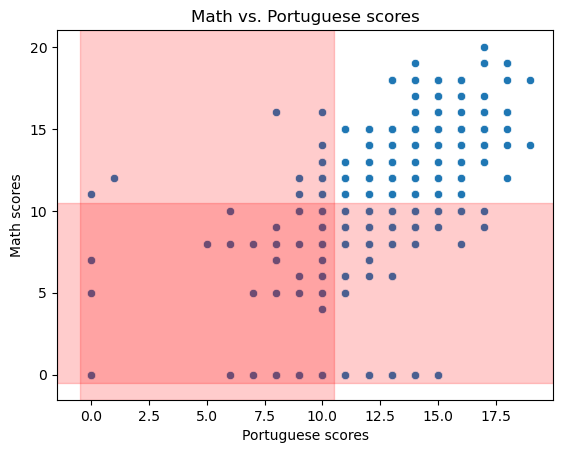

In [296]:
sns.scatterplot(data=df, x='G3_por', y='G3_mat')
plt.axvspan(-0.5, 10.5, color='red', alpha=0.2)
plt.axhspan(-0.5, 10.5, color='red', alpha=0.2)
plt.xlabel("Portuguese scores")
plt.ylabel("Math scores")
plt.title("Math vs. Portuguese scores")
plt.show()
plt.show()

In [298]:
scores = df[['G1_mat', 'G2_mat', 'G3_mat', 'G1_por', 'G2_por', 'G3_por']]
scores.head()

G1_mat  G2_mat  G3_mat  G1_por  G2_por  G3_por
0       5       6       6       0      11      11
1       5       5       6       9      11      11
2       7       8      10      12      13      12
3      15      14      15      14      14      14
4       6      10      10      11      13      13

In [299]:
# Look at scores throughout semester for multiple studens
id_list = []
MP_list = []
score_list = []
class_list = []

for index in range(50):
    student = scores.iloc[index, :]    
    
    for a in range(6):
        id_list.append(index)
    
    for b in range(2):
        MP_list.append('G1')
        MP_list.append('G2')
        MP_list.append('G3')
        
    for c in range(6):
        score_list.append(student.iloc[c])
    
    for d in range(3):
        class_list.append('mat')
    for e in range(3):
        class_list.append('por')
    
df_scores = pd.DataFrame({'id': id_list, 'MP': MP_list, 'score': score_list, 'class': class_list})
df_scores

id  MP  score class
0     0  G1      5   mat
1     0  G2      6   mat
2     0  G3      6   mat
3     0  G1      0   por
4     0  G2     11   por
..   ..  ..    ...   ...
295  49  G2      7   mat
296  49  G3      7   mat
297  49  G1     13   por
298  49  G2     12   por
299  49  G3     12   por

[300 rows x 4 columns]

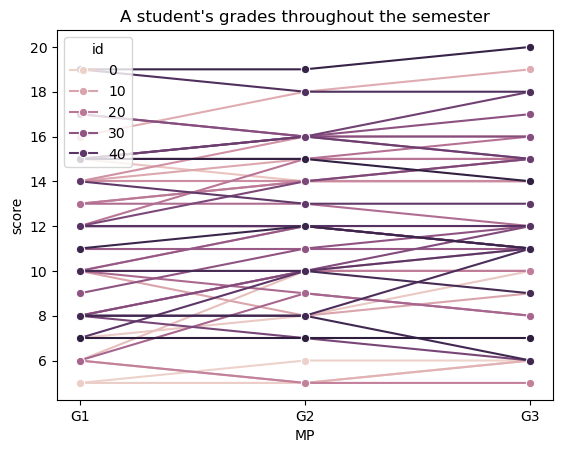

In [300]:
# Timeline of each student (math scores)
sns.lineplot(data=df_scores[df_scores['class']=='mat'], x='MP', y='score', hue='id', marker='o')
plt.title("A student's grades throughout the semester")
plt.show()

In [301]:
# Calculate difference in grade
# in main df
df.loc[:, 'G2_mat_diff'] = df.loc[:, 'G2_mat'] - df.loc[:, 'G1_mat']
df.loc[:, 'G3_mat_diff'] = df.loc[:, 'G3_mat'] - df.loc[:, 'G2_mat']
df.loc[:, 'G2_por_diff'] = df.loc[:, 'G2_por'] - df.loc[:, 'G1_por']
df.loc[:, 'G3_por_diff'] = df.loc[:, 'G3_por'] - df.loc[:, 'G2_por']

# in smaller scores df
scores.loc[:, 'G2_mat_diff'] = scores.loc[:, 'G2_mat'] - scores.loc[:, 'G1_mat']
scores.loc[:, 'G3_mat_diff'] = scores.loc[:, 'G3_mat'] - scores.loc[:, 'G2_mat']
scores.loc[:, 'G2_por_diff'] = scores.loc[:, 'G2_por'] - scores.loc[:, 'G1_por']
scores.loc[:, 'G3_por_diff'] = scores.loc[:, 'G3_por'] - scores.loc[:, 'G2_por']
scores.head()

C:\Users\yenmi\AppData\Local\Temp\ipykernel_8000\2496401681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.loc[:, 'G2_mat_diff'] = scores.loc[:, 'G2_mat'] - scores.loc[:, 'G1_mat']
C:\Users\yenmi\AppData\Local\Temp\ipykernel_8000\2496401681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.loc[:, 'G3_mat_diff'] = scores.loc[:, 'G3_mat'] - scores.loc[:, 'G2_mat']
C:\Users\yenmi\AppData\Local\Temp\ipykernel_8000\2496401681.py:11: SettingWithCopyWarning: 
A value is trying to be set on a 

G1_mat  G2_mat  G3_mat  G1_por  G2_por  G3_por  G2_mat_diff  G3_mat_diff  \
0       5       6       6       0      11      11            1            0   
1       5       5       6       9      11      11            0            1   
2       7       8      10      12      13      12            1            2   
3      15      14      15      14      14      14           -1            1   
4       6      10      10      11      13      13            4            0   

   G2_por_diff  G3_por_diff  
0           11            0  
1            2            0  
2            1           -1  
3            0            0  
4            2            0

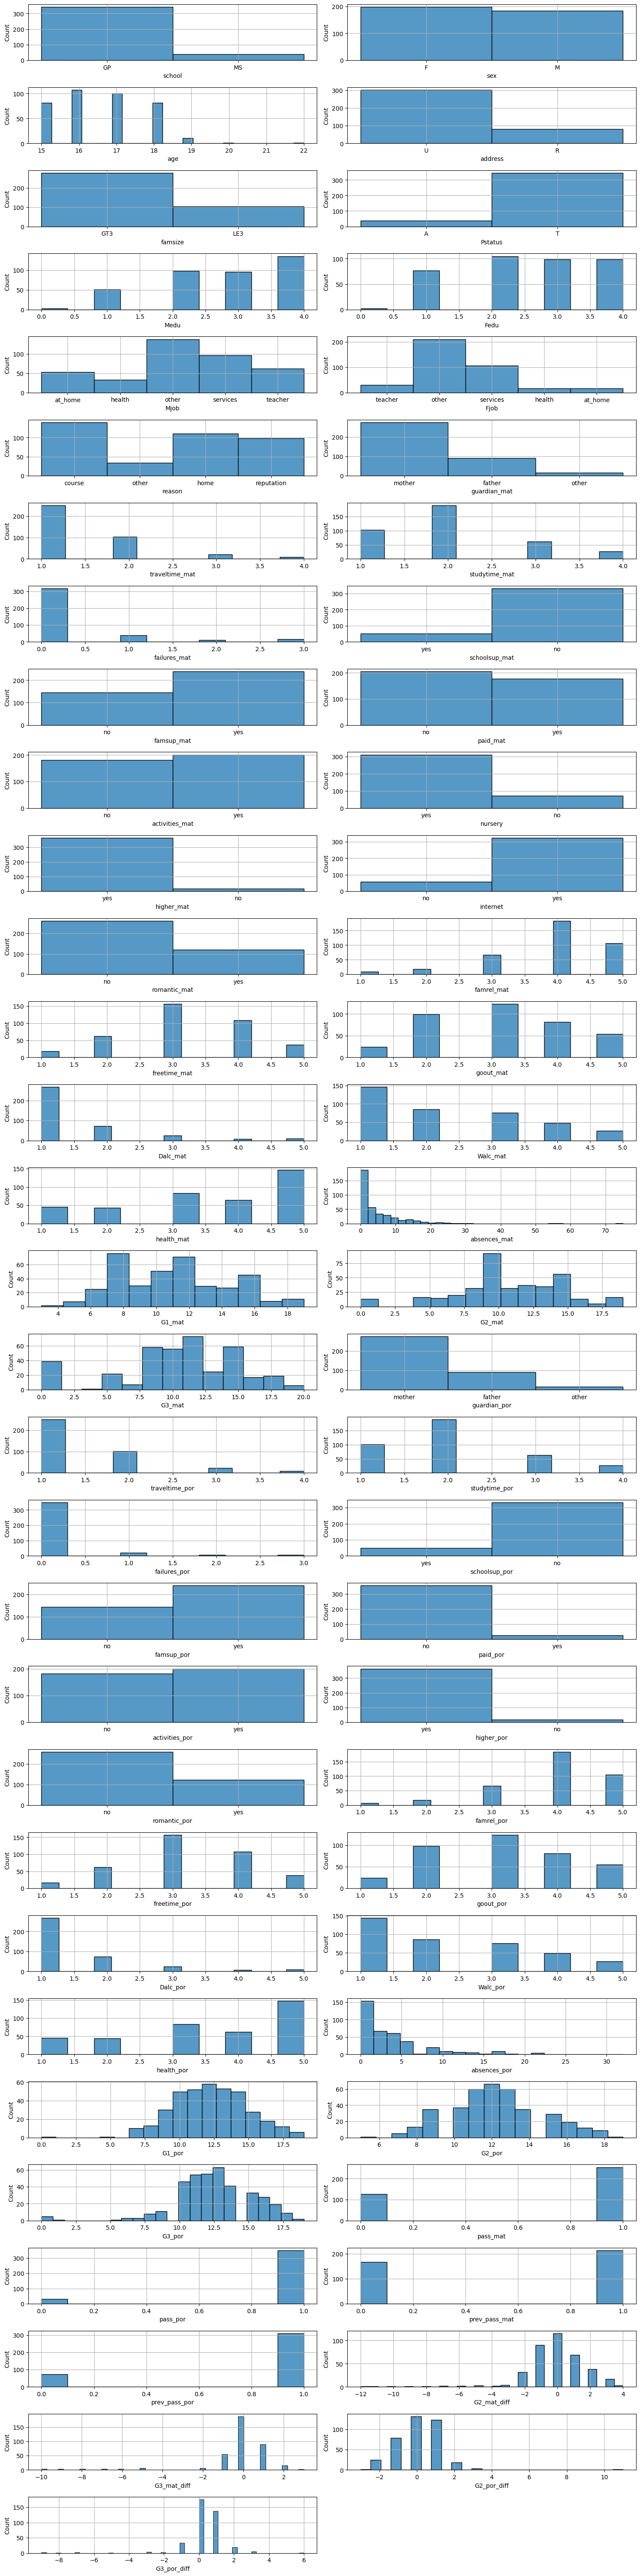

In [302]:
# Histograms of features
columns = df.columns
fig, axes = plt.subplots(31, 2, figsize=(15, 60))
x = 0
for i in range(31):
    for j in range(2):
        if x != 61:
            sns.histplot(data=df, x=columns[x], ax=axes[i, j])
            # axes[i, j].title.set_text("Login count for all " + login_day + "s")
            # axes[i, j].tick_params(axis='x', rotation=45)
            axes[i, j].grid(True)
            # axes[i, j].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            x += 1
        
fig.delaxes(axes[30, 1])
plt.tight_layout()
plt.show()

In [303]:
# Convert everything into integers or Boolean
print(df.select_dtypes(include=['object']).columns)
df.select_dtypes(include=['object'])

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian_mat', 'schoolsup_mat', 'famsup_mat', 'paid_mat',
       'activities_mat', 'nursery', 'higher_mat', 'internet', 'romantic_mat',
       'guardian_por', 'schoolsup_por', 'famsup_por', 'paid_por',
       'activities_por', 'higher_por', 'romantic_por'],
      dtype='object')


school sex address famsize Pstatus      Mjob      Fjob  reason  \
0       GP   F       U     GT3       A   at_home   teacher  course   
1       GP   F       U     GT3       T   at_home     other  course   
2       GP   F       U     LE3       T   at_home     other   other   
3       GP   F       U     GT3       T    health  services    home   
4       GP   F       U     GT3       T     other     other    home   
..     ...  ..     ...     ...     ...       ...       ...     ...   
377     MS   F       U     LE3       T   teacher  services  course   
378     MS   F       U     GT3       T     other     other  course   
379     MS   F       U     GT3       T     other     other  course   
380     MS   M       U     LE3       T  services  services  course   
381     MS   M       R     LE3       T  services     other  course   

    guardian_mat schoolsup_mat famsup_mat paid_mat activities_mat nursery  \
0         mother           yes         no       no             no     yes   
1         father            no        yes       no             no      no   
2         mother           yes         no      yes             no     yes   
3         mother            no        yes      yes            yes     yes   
4         father            no        yes      yes             no     yes   
..           ...           ...        ...      ...            ...     ...   
377       mother            no        yes      yes             no     yes   
378       mother            no         no       no            yes     yes   
379       mother            no         no       no            yes     yes   
380       mother            no         no       no             no      no   
381       mother            no         no       no             no      no   

    higher_mat internet romantic_mat guardian_por schoolsup_por famsup_por  \
0          yes       no           no       mother           yes         no   
1          yes      yes           no       father            no        yes   
2          yes      yes           no       mother           yes         no   
3          yes      yes          yes       mother            no        yes   
4          yes       no           no       father            no        yes   
..         ...      ...          ...          ...           ...        ...   
377        yes      yes           no       mother            no        yes   
378        yes       no           no       mother            no         no   
379        yes       no           no       mother            no         no   
380        yes      yes           no       mother            no         no   
381        yes      yes           no       mother            no         no   

    paid_por activities_por higher_por romantic_por  
0         no             no        yes           no  
1         no             no        yes           no  
2         no             no        yes           no  
3         no            yes        yes          yes  
4         no             no        yes           no  
..       ...            ...        ...          ...  
377       no             no        yes           no  
378       no            yes        yes          yes  
379       no            yes        yes           no  
380       no             no        yes           no  
381       no             no        yes           no  

[382 rows x 24 columns]

In [304]:
columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'guardian_mat', 'schoolsup_mat', 'famsup_mat', 'paid_mat', 'activities_mat', 'nursery', 'higher_mat', 'internet', 'romantic_mat', 'guardian_por', 'schoolsup_por', 'famsup_por', 'paid_por', 'activities_por', 'higher_por', 'romantic_por']
df = pd.get_dummies(data=df, columns=columns, drop_first=True)

columns = ['Mjob', 'Fjob', 'reason']
df = pd.get_dummies(data=df, columns=columns, drop_first=False)

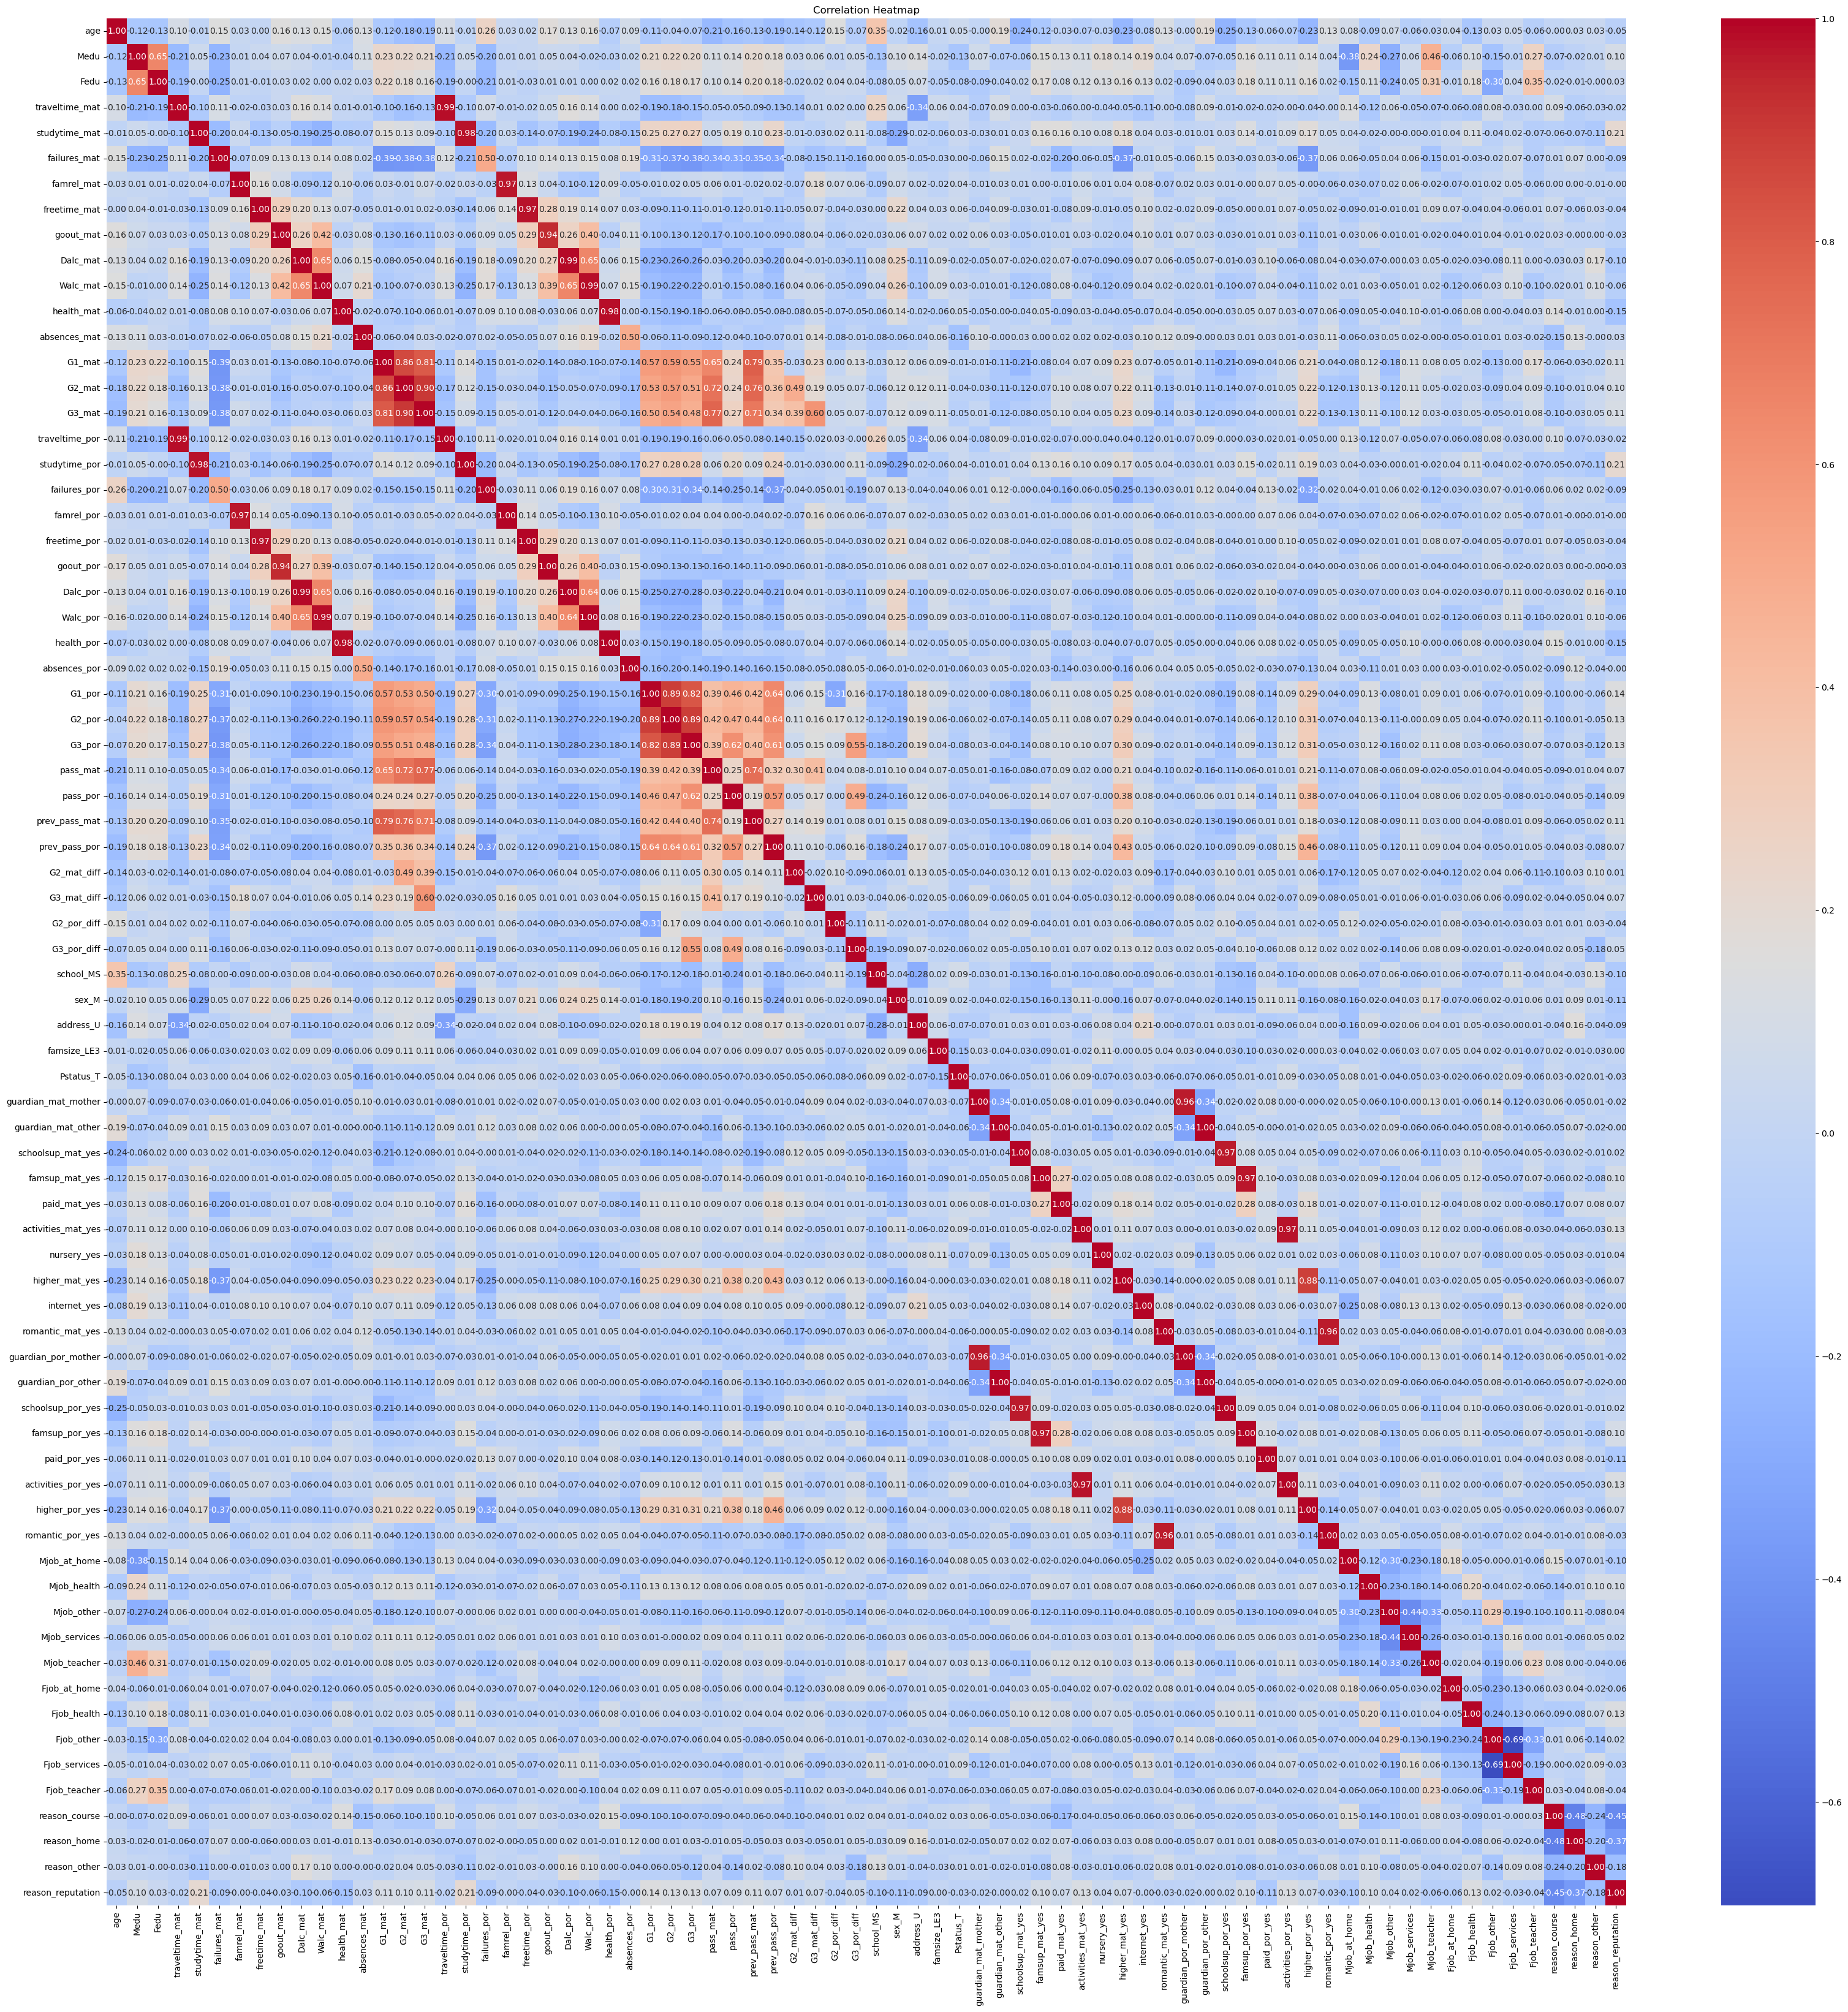

In [332]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

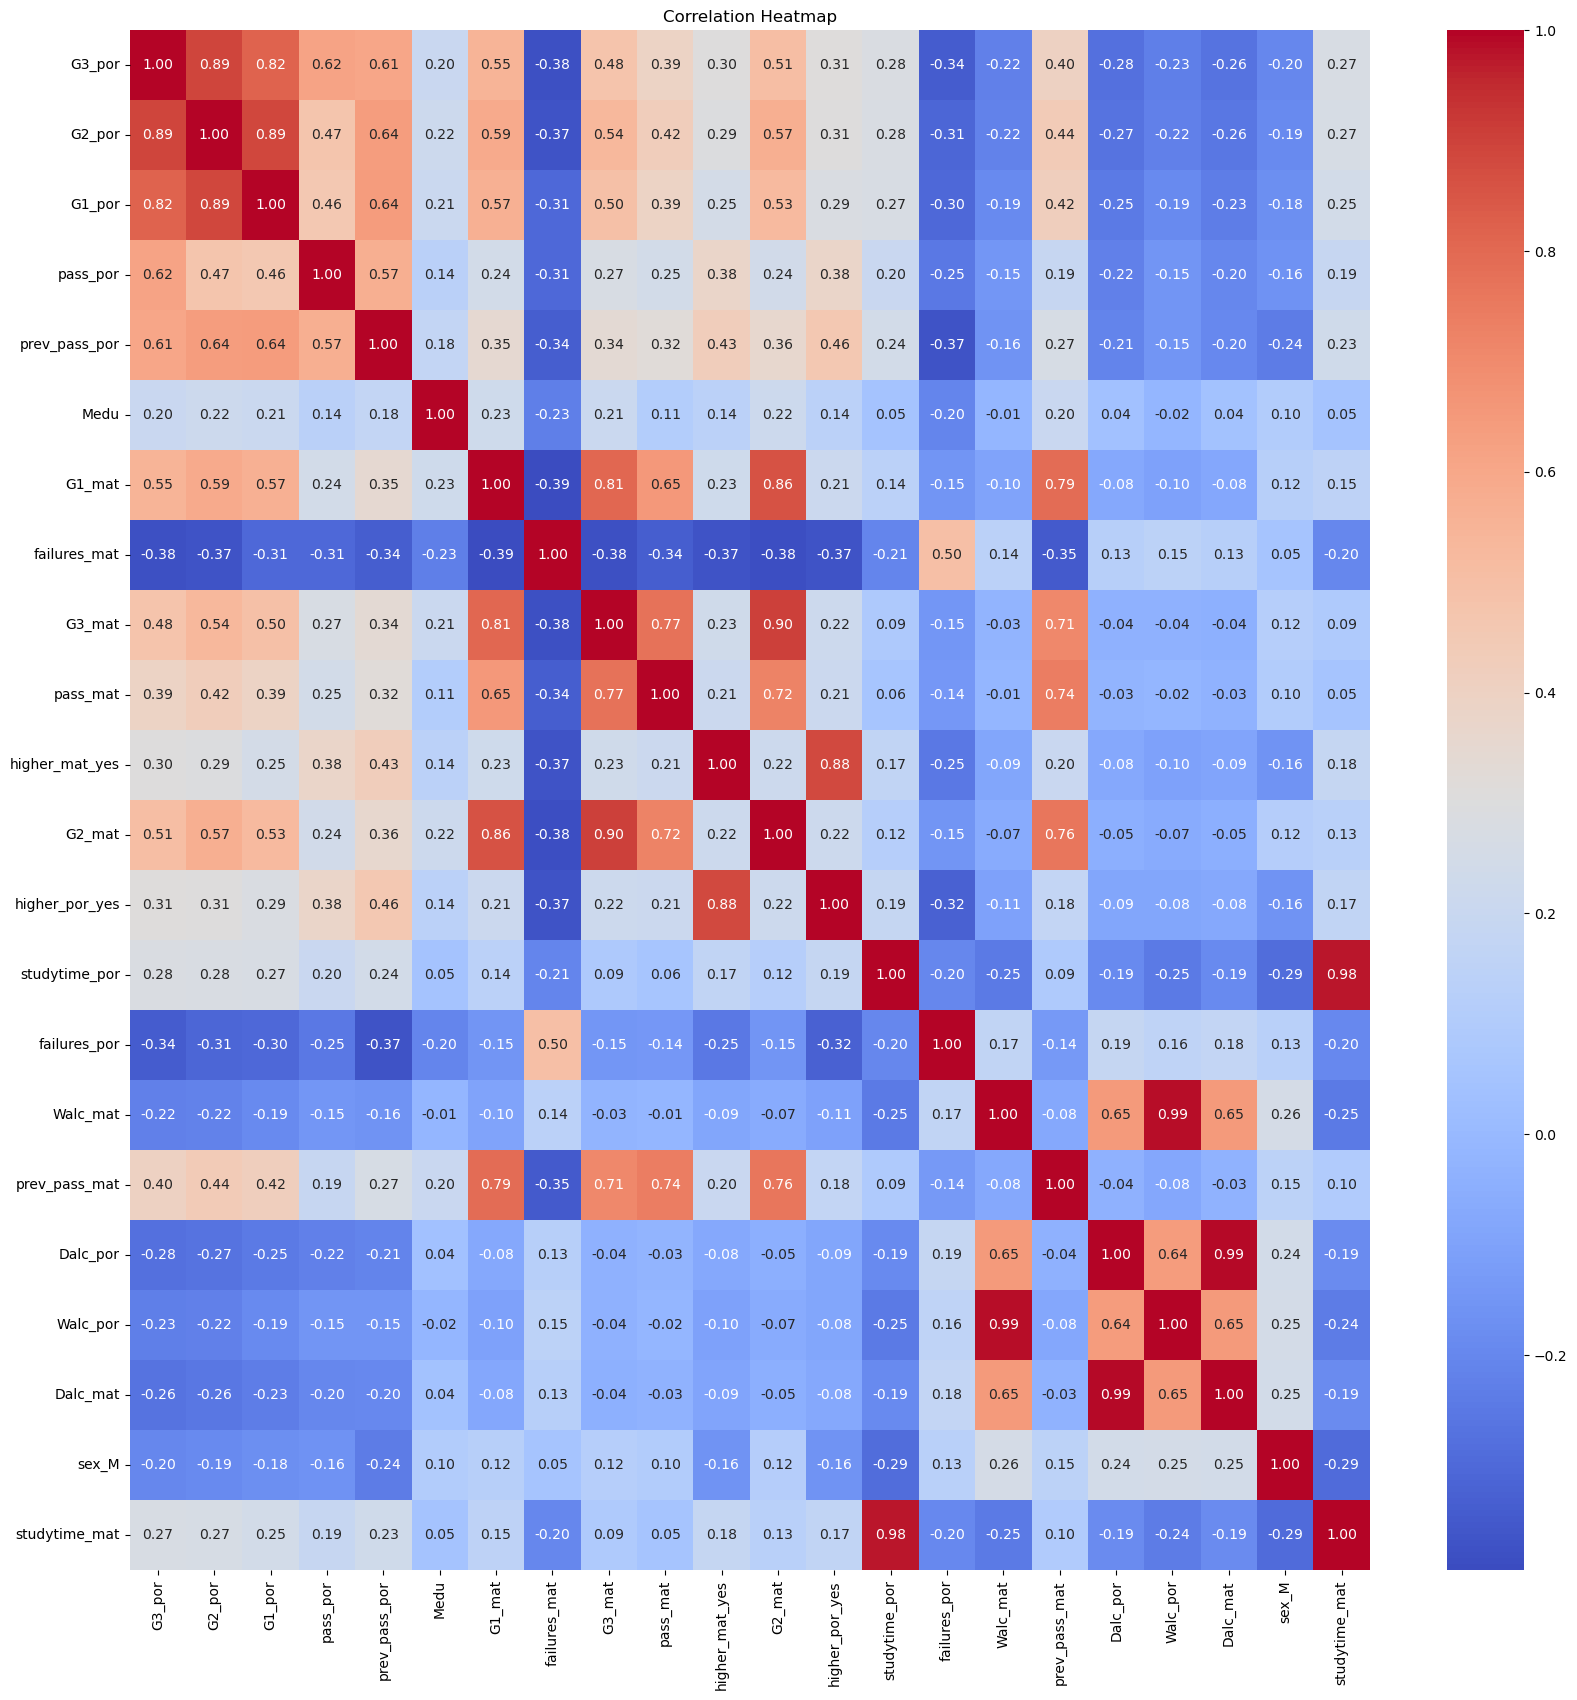

In [402]:
# More impactful correlation heatmap
df_temp = correlation_matrix[((correlation_matrix>0.2) & (correlation_matrix<1))| (correlation_matrix<-0.2)]
columns = df_temp.notna().sum().sort_values(ascending=False).head(22).index
columns = ['G3_por', 'G2_por', 'G1_por', 'pass_por', 'prev_pass_por', 'Medu',
       'G1_mat', 'failures_mat', 'G3_mat', 'pass_mat', 'higher_mat_yes',
       'G2_mat', 'higher_por_yes', 'studytime_por', 'failures_por', 'Walc_mat',
       'prev_pass_mat', 'Dalc_por', 'Walc_por', 'Dalc_mat', 'sex_M',
       'studytime_mat']
df_temp2 = df[columns]

correlation_matrix = df_temp2.corr()
correlation_matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

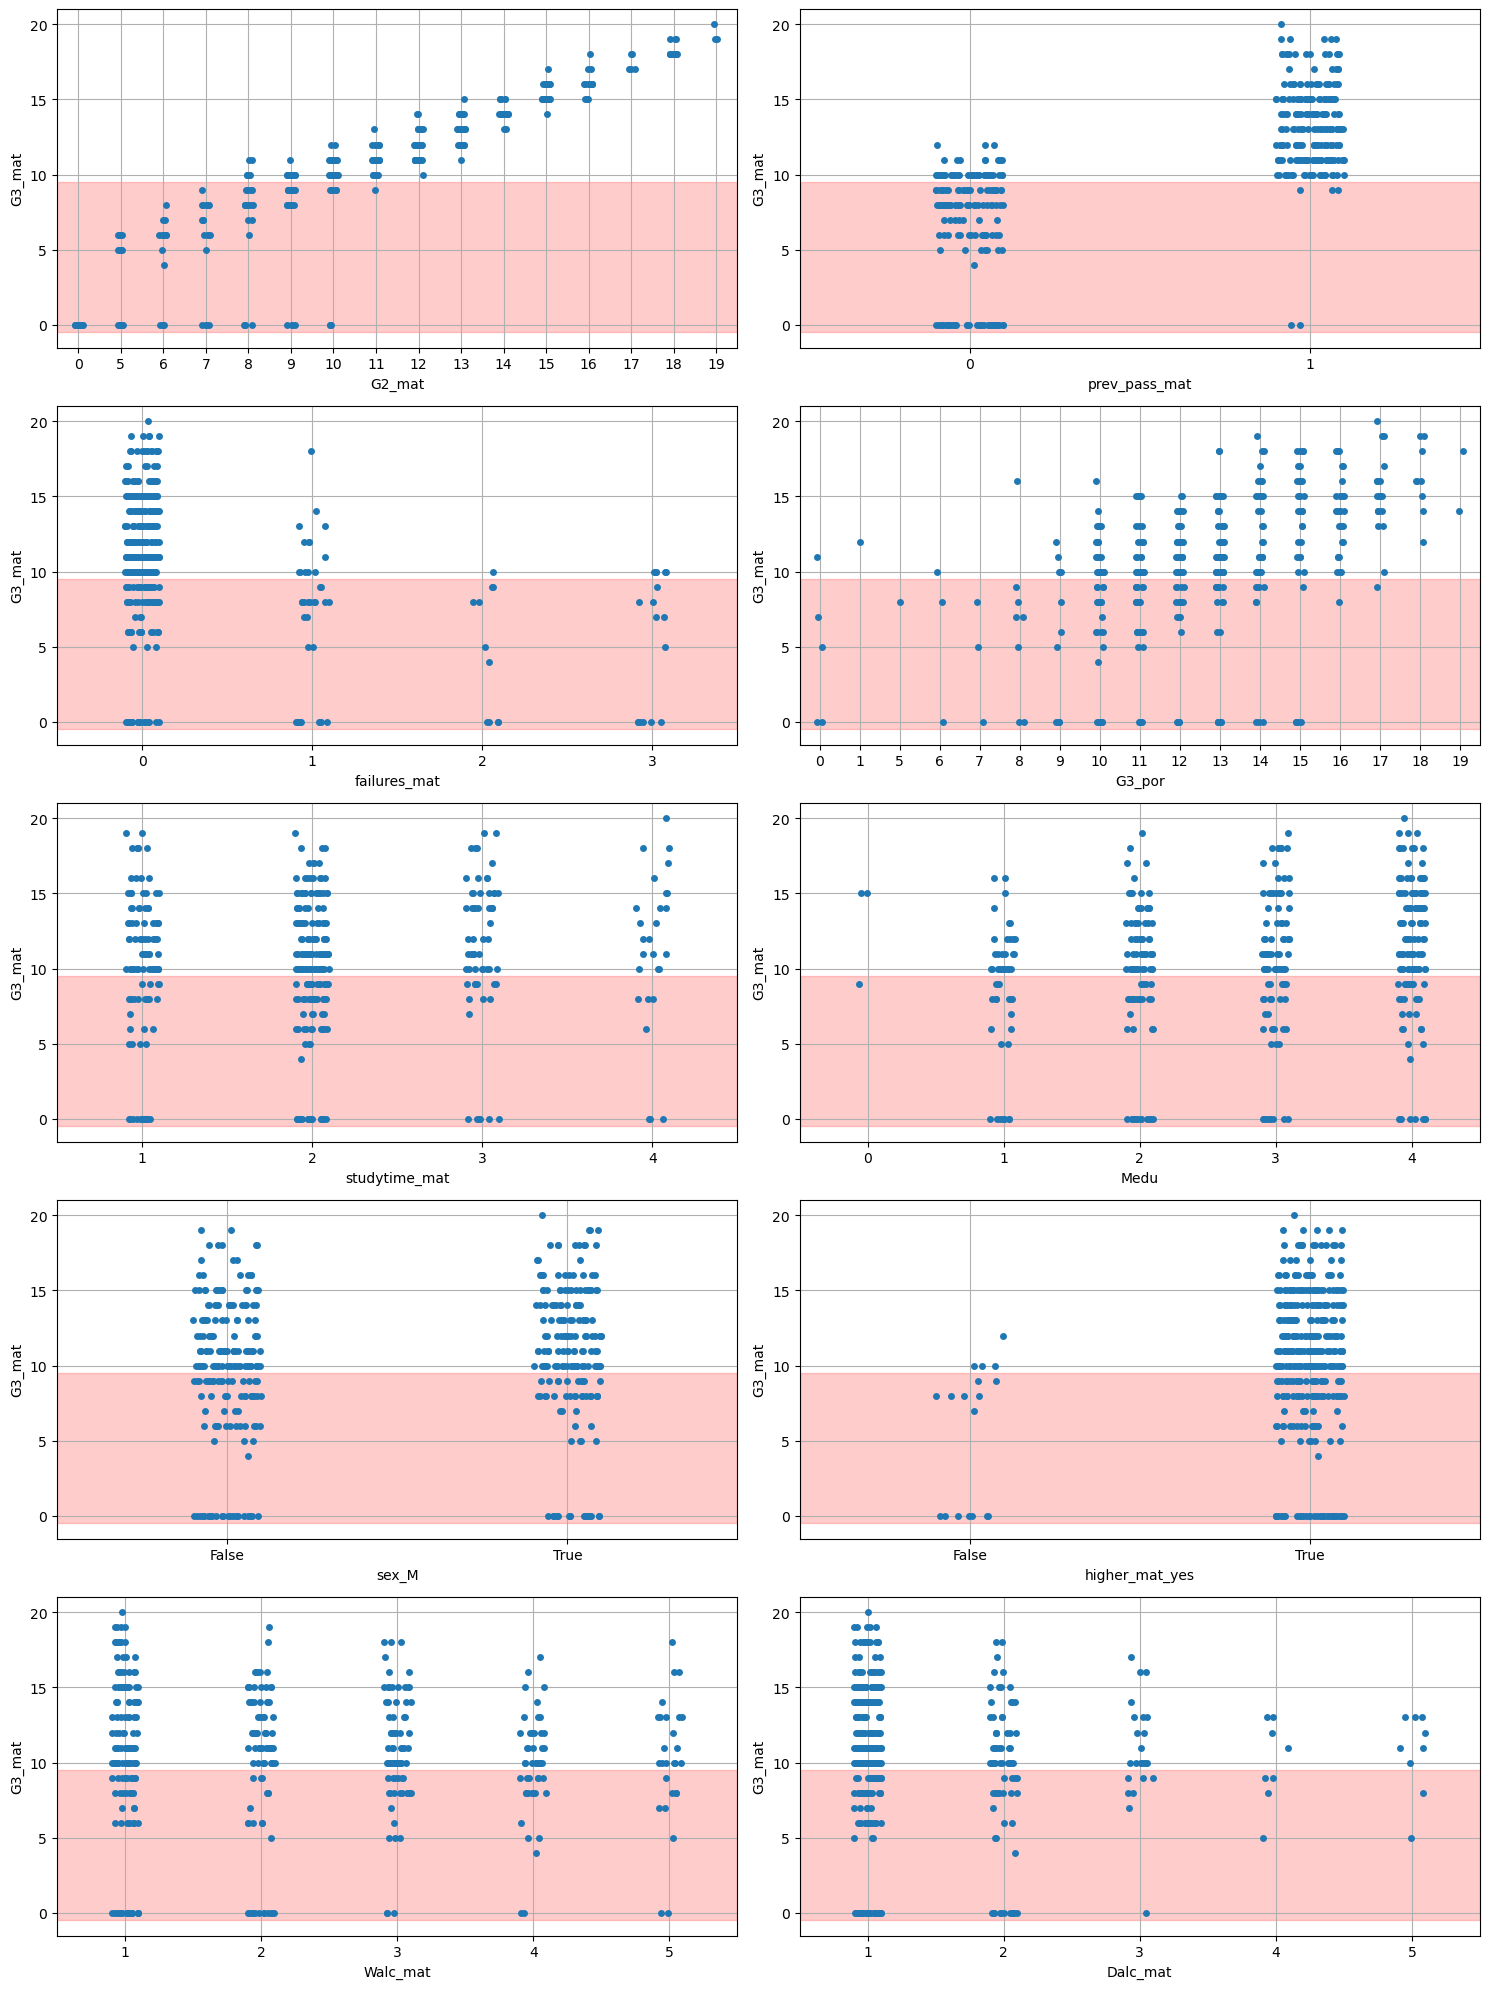

In [461]:
# Boxplots of features for Math

columns = ['G2_mat', 'prev_pass_mat', 'failures_mat', 'G3_por', 'studytime_mat', 'Medu', 'sex_M', 'higher_mat_yes', 'Walc_mat', 'Dalc_mat']
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
x = 0
for i in range(5):
    for j in range(2):
        if x != 10:
            sns.stripplot(data=df, x=columns[x], y='G3_mat', ax=axes[i, j])
            axes[i, j].axhspan(-0.5, 9.5, color='red', alpha=0.2)
            # axes[i, j].title.set_text("Login count for all " + login_day + "s")
            # axes[i, j].tick_params(axis='x', rotation=45)
            axes[i, j].grid(True)
            # axes[i, j].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            x += 1
        
# fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()

# How does someone have a G2 grade of 5-10 and then drop to 0?!

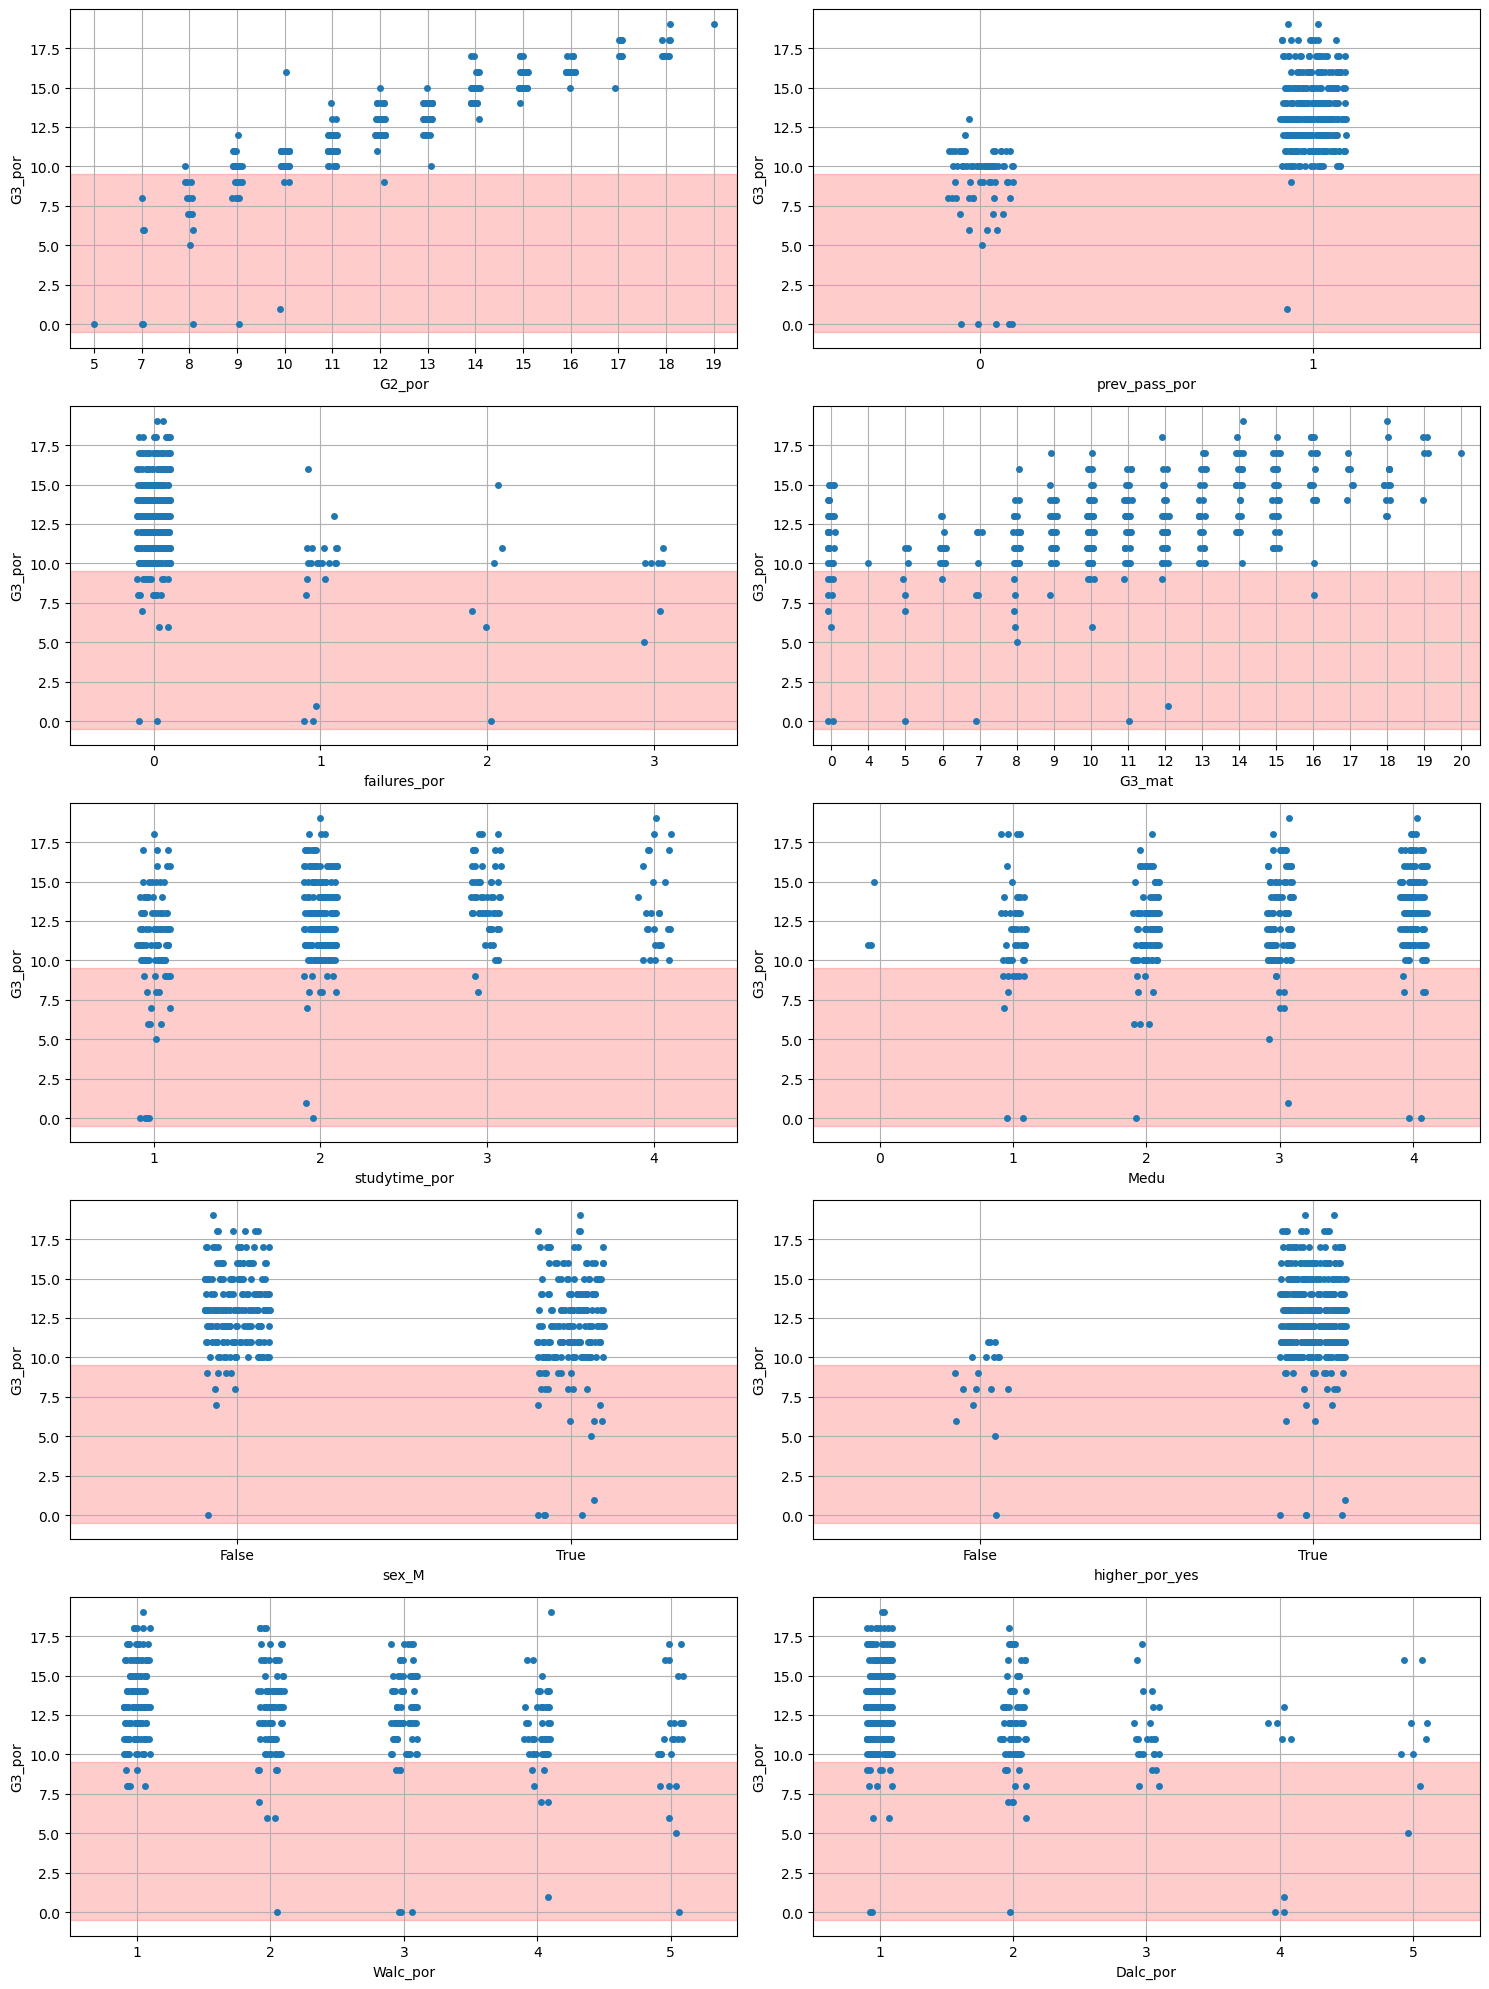

In [465]:
# Boxplots of features for Portuguese

columns = ['G2_por', 'prev_pass_por', 'failures_por', 'G3_mat', 'studytime_por', 'Medu', 'sex_M', 'higher_por_yes', 'Walc_por', 'Dalc_por']
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
x = 0
for i in range(5):
    for j in range(2):
        if x != 10:
            sns.stripplot(data=df, x=columns[x], y='G3_por', ax=axes[i, j])
            axes[i, j].axhspan(-0.5, 9.5, color='red', alpha=0.2)
            # axes[i, j].title.set_text("Login count for all " + login_day + "s")
            # axes[i, j].tick_params(axis='x', rotation=45)
            axes[i, j].grid(True)
            # axes[i, j].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            x += 1
        
# fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()

# How does someone have a G2 grade of 5-10 and then drop to 0?!

## 3) Preprocessing and Splitting the Data

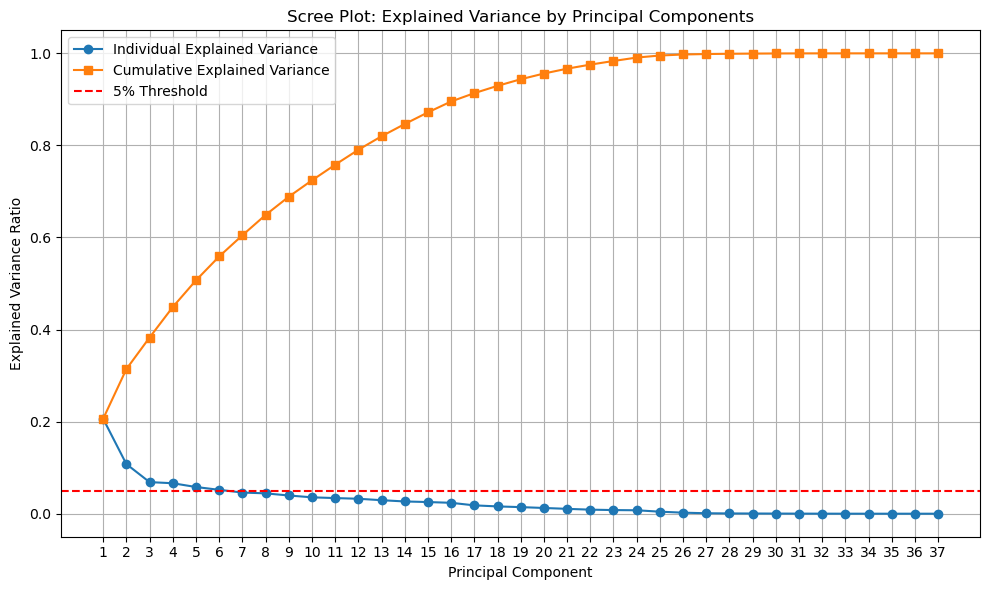

In [572]:
# Select only numeric features
numeric_cols = df.select_dtypes(include='number').columns.tolist()
combined_numeric = df[numeric_cols]

# Standardize the numeric data
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_numeric)

# Apply PCA with all components to capture full variance
pca_full = PCA()
pca_full.fit(combined_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='s', label='Cumulative Explained Variance')
plt.axhline(y=0.05, color='r', linestyle='--', label='5% Threshold')
plt.title('Scree Plot: Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio)+1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [574]:
# Get the PCA loadings (aka component weights)
loadings = pd.DataFrame(pca_full.components_.T, columns=[f'PC{i+1}' for i in range(len(pca_full.components_))], index=numeric_cols)

# Get the top contributing features for the first few components
top_n = 5
top_features_by_pc = {}

for pc in loadings.columns[:5]:  # Let’s inspect the first 5 PCs
    sorted_loadings = loadings[pc].abs().sort_values(ascending=False)
    top_features_by_pc[pc] = sorted_loadings.head(top_n)

top_features_by_pc


{'PC1': G2_por    0.297660
 G3_por    0.295224
 G1_por    0.281001
 G2_mat    0.273187
 G1_mat    0.268734
 Name: PC1, dtype: float64,
 'PC2': Walc_mat    0.359527
 Walc_por    0.356431
 Dalc_por    0.343187
 Dalc_mat    0.342516
 G3_mat      0.244417
 Name: PC2, dtype: float64,
 'PC3': famrel_mat      0.458190
 famrel_por      0.456600
 freetime_mat    0.371400
 freetime_por    0.364379
 health_mat      0.208479
 Name: PC3, dtype: float64,
 'PC4': goout_mat     0.324015
 goout_por     0.318528
 health_por    0.282217
 health_mat    0.280905
 pass_mat      0.234293
 Name: PC4, dtype: float64,
 'PC5': traveltime_por    0.530112
 traveltime_mat    0.529772
 Fedu              0.292011
 Medu              0.289109
 famrel_mat        0.193992
 Name: PC5, dtype: float64}

In [1050]:
# Split data into training and test sets for Regressor and Classifier models (and for Math and Portuguese)
# Only contains features that are course-agnostic, or course-specific only. Excludes any information about grades except for the G3 grade of the other course

# Purpose of Regressors models is to predict what grade they'll get + identify features that contribute to their grade
regressor_math_columns = ['age', 'Medu', 'Fedu', 'traveltime_mat', 'studytime_mat', 'failures_mat', 'famrel_mat', 'freetime_mat', 'goout_mat', 'Dalc_mat', 'Walc_mat', 'health_mat', 'absences_mat', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'guardian_mat_mother', 'guardian_mat_other', 'schoolsup_mat_yes', 'famsup_mat_yes', 'paid_mat_yes', 'activities_mat_yes', 'nursery_yes', 'higher_mat_yes', 'internet_yes', 'romantic_mat_yes', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'G3_por']
X_regressor_math = df[regressor_math_columns]
y_regressor_math = df['G3_mat']

regressor_por_columns = ['age', 'Medu', 'Fedu', 'traveltime_por', 'studytime_por', 'failures_por', 'famrel_por', 'freetime_por', 'goout_por', 'Dalc_por', 'Walc_por', 'health_por', 'absences_por', 'G3_mat', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'nursery_yes', 'internet_yes', 'guardian_por_mother', 'guardian_por_other', 'schoolsup_por_yes', 'famsup_por_yes', 'paid_por_yes', 'activities_por_yes', 'higher_por_yes', 'romantic_por_yes', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation']
X_regressor_por = df[regressor_por_columns]
y_regressor_por = df['G3_por']


# Purpose of Classifier models is to figure out whether or not they'll pass + identify features that contribute to their success
classifier_math_columns = ['age', 'Medu', 'Fedu', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'nursery_yes', 'internet_yes', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'traveltime_mat', 'studytime_mat', 'failures_mat', 'famrel_mat', 'freetime_mat', 'goout_mat', 'Dalc_mat', 'Walc_mat', 'health_mat', 'absences_mat', 'guardian_mat_mother', 'guardian_mat_other', 'schoolsup_mat_yes', 'famsup_mat_yes', 'paid_mat_yes', 'activities_mat_yes', 'higher_mat_yes', 'romantic_mat_yes']
X_classifier_math = df[classifier_math_columns]
y_classifier_math = df['pass_mat']

classifier_por_columns = ['age', 'Medu', 'Fedu', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'nursery_yes', 'internet_yes', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'traveltime_por', 'studytime_por', 'failures_por', 'famrel_por', 'freetime_por', 'goout_por', 'Dalc_por', 'Walc_por', 'health_por', 'absences_por', 'guardian_por_mother', 'guardian_por_other', 'schoolsup_por_yes', 'famsup_por_yes', 'paid_por_yes', 'activities_por_yes', 'higher_por_yes', 'romantic_por_yes']
X_classifier_por = df[classifier_por_columns]
y_classifier_por = df['pass_por']

## 4) Modeling and Evaluation Metrics

In [950]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier

In [856]:
# Define modeling function
# Fits, predicts, evaluates, scatter plot
def runRegressorModel(model):
    model.fit(X_train, y_train) # Train the classifier on the training data
    y_pred = model.predict(X_test) # Make predictions on the test data
    return y_pred

def RegressorEvalMetrics(model_name, model, y_pred):
    # Evaluate model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Scatter plot comparing actual data with predictions
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[0])
    axes[0].plot([0, 20], [0, 20], 'r--')  # 45-degree line
    axes[0].set_xlabel('Actual G3')
    axes[0].set_ylabel('Predicted G3')
    axes[0].set_title('Predicted vs. Actual Final Grades')
    axes[0].grid(True)

     # Residuals plot
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_xlabel('Predicted G3')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residuals vs Predicted Values')
    axes[1].grid(True)
   
    plt.tight_layout()
    plt.show()
    
    df = pd.DataFrame({'Model': model_name, 'Mean Absolute Error': mae, 'Mean Squared Error': mse, 'Root Mean Squared Error': rmse, 'R Squared': r2}, index=[0])
    print(df)
    return df 

### Regressor Models - Math

In [1028]:
# REGRESSOR - MATH
X_train, X_test, y_train, y_test = train_test_split(X_regressor_math, y_regressor_math, test_size=0.3, random_state=42)

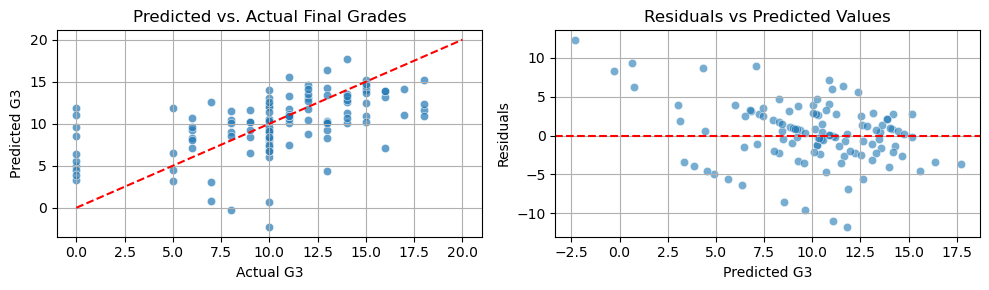

               Model  Mean Absolute Error  Mean Squared Error  \
0  Linear Regression             2.959499           15.767094   

   Root Mean Squared Error  R Squared  
0                  3.97078   0.183121  
Coefficients: [-0.75899656  0.08094746  0.09592945 -0.83844894  0.08640742 -1.33708904
 -0.03024104  0.21574085 -0.21910758  0.10780551  0.36486346  0.0149797
  0.06850781  1.83154275  1.75594967 -0.33009956  0.96399569 -0.3919594
 -0.06308409  1.16321236 -0.61616684 -0.92603037  0.88583897 -0.29555587
 -0.46684437  1.44789562 -0.18803849 -0.75738107 -0.39576529  0.71834108
  0.26416779  0.92605304 -1.51279662 -0.07712766  0.36343652 -0.65436757
 -0.29301359  0.6610723  -0.17368188 -0.80849658  0.61364348  0.36853499
  0.74578332]
Intercept: 12.768601368634156


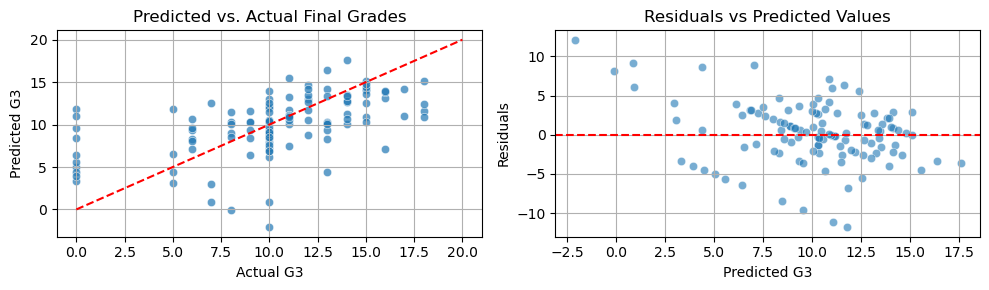

              Model  Mean Absolute Error  Mean Squared Error  \
0  Ridge Regression             2.944304             15.5594   

   Root Mean Squared Error  R Squared  
0                 3.944541   0.193881  
Coefficients: [-0.74647583  0.07951805  0.09981797 -0.81163904  0.08215208 -1.33323535
 -0.03108899  0.22156337 -0.22124744  0.11566187  0.36124662  0.01291076
  0.0672615   1.72516367  1.70963502 -0.32642864  0.94527587 -0.3915201
 -0.07782538  1.02068876 -0.58428314 -0.91608451  0.87023625 -0.29485403
 -0.45611728  1.32516649 -0.191      -0.74410256 -0.40469286  0.69148031
  0.25826787  0.91190482 -1.45696014 -0.08163945  0.35504155 -0.62168008
 -0.2692915   0.61756948 -0.18342182 -0.78781379  0.61464519  0.35659042
  0.7468406 ]
Intercept: 12.64909153523911


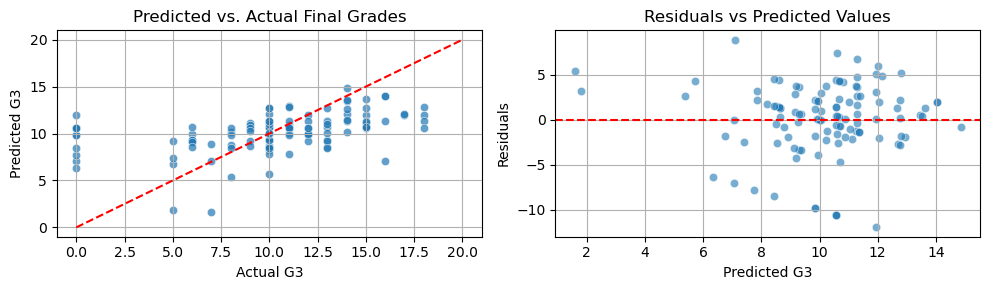

              Model  Mean Absolute Error  Mean Squared Error  \
0  Lasso Regression             2.885305           15.212926   

   Root Mean Squared Error  R Squared  
0                 3.900375   0.211832  
Coefficients: [-0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.
  0.02601738  0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.         -0.
  0.          0.         -0.         -0.          0.          0.
  0.69966158]
Intercept: 1.4547325183170923


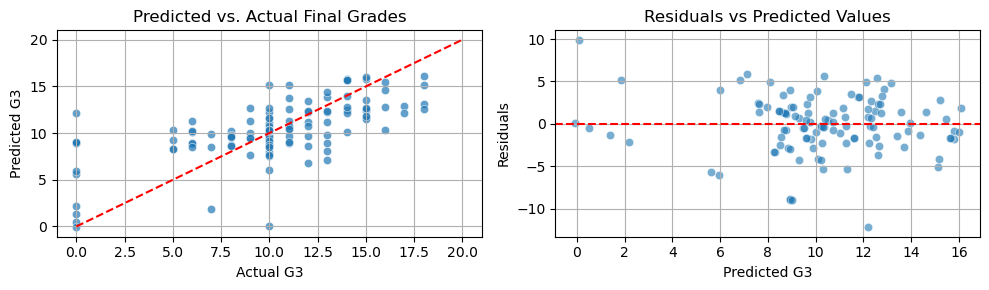

               Model  Mean Absolute Error  Mean Squared Error  \
0  Gradient Boosting             2.528591           11.252291   

   Root Mean Squared Error  R Squared  
0                 3.354443   0.417029  


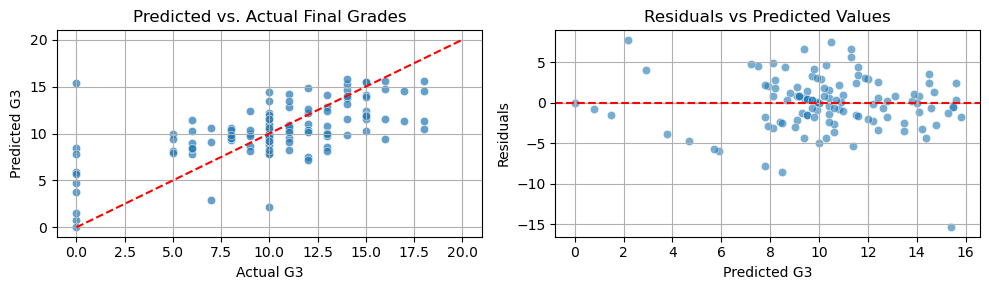

                     Model  Mean Absolute Error  Mean Squared Error  \
0  Random Forest Regressor             2.461739           11.254348   

   Root Mean Squared Error  R Squared  
0                  3.35475   0.416922  


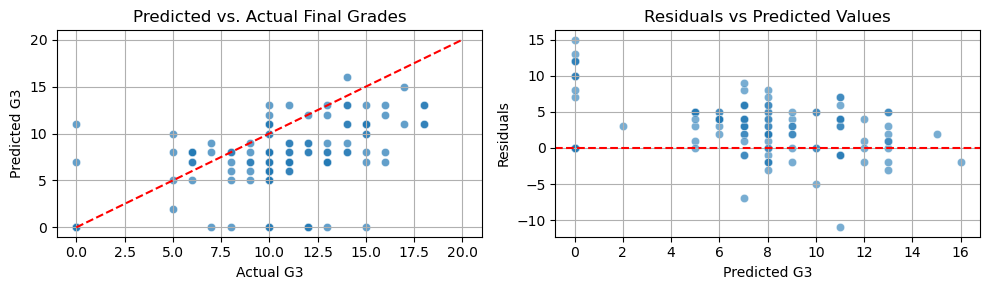

     Model  Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  \
0  XGBoost             3.791304                24.4                 4.939636   

   R Squared  
0  -0.264142  


Model  Mean Absolute Error  Mean Squared Error  \
0        Gradient Boosting             2.528591           11.252291   
0  Random Forest Regressor             2.461739           11.254348   
0         Lasso Regression             2.885305           15.212926   
0         Ridge Regression             2.944304           15.559400   
0        Linear Regression             2.959499           15.767094   
0                  XGBoost             3.791304           24.400000   

   Root Mean Squared Error  R Squared  
0                 3.354443   0.417029  
0                 3.354750   0.416922  
0                 3.900375   0.211832  
0                 3.944541   0.193881  
0                 3.970780   0.183121  
0                 4.939636  -0.264142

In [1030]:
# Run 6 different models and compare evaluation metrics:

# Linear Regression
lr = LinearRegression()

lr_y_pred = runRegressorModel(lr)
lr_eval = RegressorEvalMetrics("Linear Regression", lr, lr_y_pred)

coefficients = lr.coef_
intercept = lr.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")


# Ridge Regression
rr = Ridge(alpha=1.0) # alpha controls the strength of regularization

rr_y_pred = runRegressorModel(rr)
ridge_eval = RegressorEvalMetrics("Ridge Regression", rr, rr_y_pred)

coefficients = rr.coef_
intercept = rr.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")


# Lasso Regression
lasso = Lasso(alpha=1.0) # alpha controls the strength of regularization

lasso_y_pred = runRegressorModel(lasso)
lasso_eval = RegressorEvalMetrics("Lasso Regression", lasso, lasso_y_pred)

coefficients = lasso.coef_
intercept = lasso.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")


# Gradient Boosting Regression
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

gb = ensemble.GradientBoostingRegressor(**params)

gb_y_pred = runRegressorModel(gb)
gb_eval = RegressorEvalMetrics("Gradient Boosting", gb, gb_y_pred)


# Random Forest Regressor
params = {
    "n_estimators": 10,
    "random_state": 0,
    "oob_score": False
}

rf = RandomForestRegressor(**params)

rf_y_pred = runRegressorModel(rf)
rf_eval = RegressorEvalMetrics("Random Forest Regressor", rf, rf_y_pred)


# XG Boost
params = {
    "objective":'multi:softmax',  # Specify the objective function for multi-class classification
    "num_class":3,                # Specify the number of classes
    "n_estimators":100,           # Number of boosting rounds
    "learning_rate":0.1,          # Step size shrinkage to prevent overfitting
    "max_depth":3,                # Maximum depth of a tree
    "random_state":42             # Random seed for reproducibility
}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

xgboost = XGBClassifier(**params)


xgboost_y_pred = runRegressorModel(xgboost)
xgboost_eval = RegressorEvalMetrics("XGBoost", xgboost, xgboost_y_pred)


# Compare all evaluation metrics
evaluation_metrics = pd.concat([lr_eval, ridge_eval, lasso_eval, gb_eval, rf_eval, xgboost_eval]) # Stacks df3 below df1
evaluation_metrics.sort_values(by='Root Mean Squared Error', ascending=True)

**Tuning Hyperparameters - Gradient Boosting**

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.7}
Best cross-validated RMSE: 3.31
Test RMSE: 4.11
Test R²: 0.12


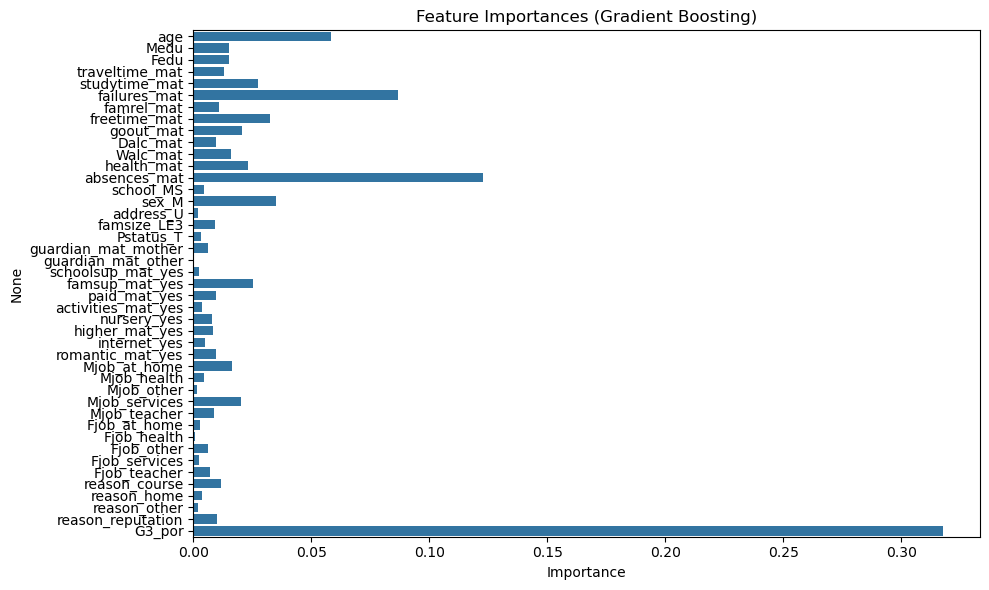

In [983]:
# Negate RMSE since GridSearchCV minimizes the score
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Set up parameter grid. Use "RandomizedSearchCV" to go faster
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 1.0]}

# Fit with cross validation
gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Examine best model
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated RMSE: {-grid_search.best_score_:.2f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

# Visualize feature importances
feature_importance = best_model.feature_importances_
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'PC{i+1}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [984]:
# Retraining the model - Gradient Boosting with best parameters
gbr = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=500,
    subsample=0.7,
    random_state=42)

# Cross-validation (5-fold)
cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Train on full training set and evaluate on test set
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

# Calculate RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

cv_rmse_mean = -np.mean(cv_scores)
cv_rmse_std = np.std(cv_scores)

(rmse, r2, cv_rmse_mean, cv_rmse_std)

(4.113978668389561,
 0.12314015724728733,
 3.3098027161924257,
 0.3576031113599822)

**Tuning Hyperparameters - Random Forest Regressor**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best cross-validated RMSE: 3.33
Test RMSE: 4.21
Test R²: 0.08


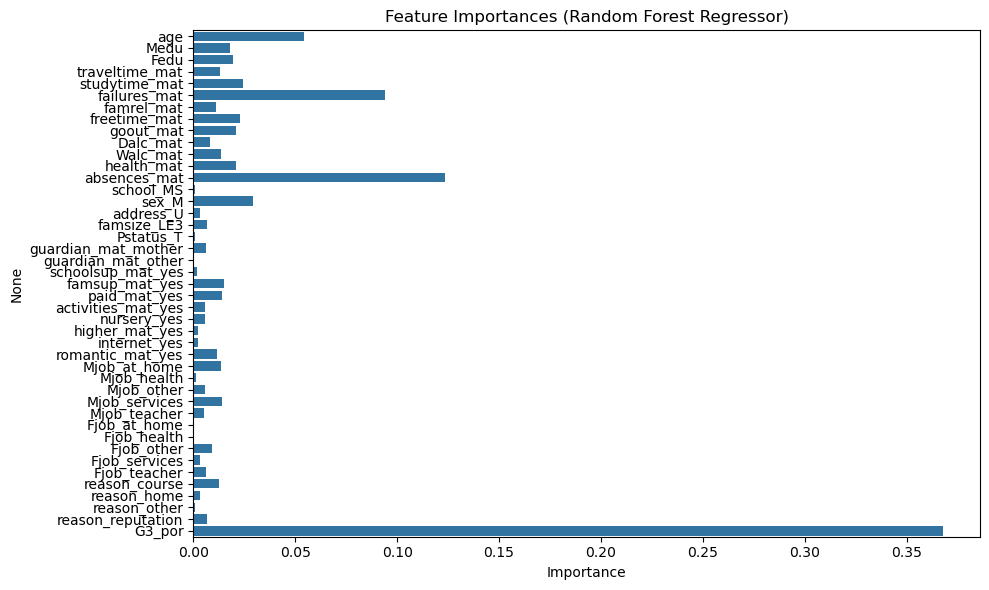

In [990]:
# Define RMSE Scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Set up parameter grid. Use "RandomizedSearchCV" to go faster
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Fit with cross validation
rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=rmse_scorer,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search.fit(X_train, y_train)

# Examine best model
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validated RMSE: {-random_search.best_score_:.2f}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

# Visualize feature importances
feature_importance = best_model.feature_importances_
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'PC{i+1}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importances (Random Forest Regressor)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [993]:
# Retraining the model - Random Forest with best parameters
rf = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=4,
    min_samples_split=2,
    max_features=None,
    max_depth=10,
    bootstrap=True)

# Cross-validation (5-fold)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Train on full training set and evaluate on test set
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

cv_rmse_mean = -np.mean(cv_scores)
cv_rmse_std = np.std(cv_scores)

(rmse, r2, cv_rmse_mean, cv_rmse_std)

(4.180877302810901,
 0.09439053037313327,
 3.313558623807784,
 0.39186410779702696)

### Regressor Models - Portuguese

In [998]:
# REGRESSOR - Portuguese
X_train, X_test, y_train, y_test = train_test_split(X_regressor_por, y_regressor_por, test_size=0.3, random_state=42)

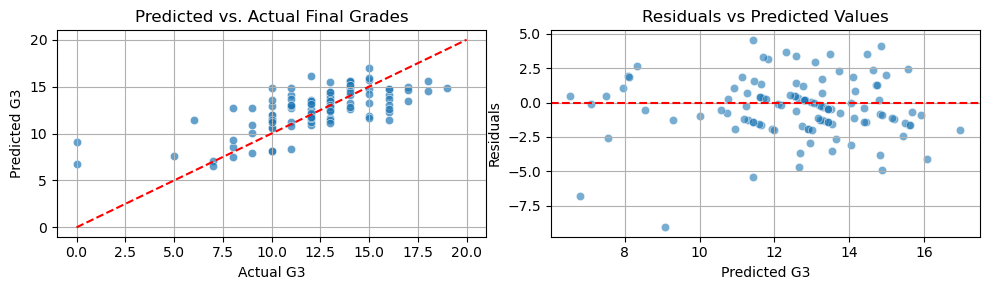

               Model  Mean Absolute Error  Mean Squared Error  \
0  Linear Regression             1.632927            4.855443   

   Root Mean Squared Error  R Squared  
0                 2.203507   0.471731  
Coefficients: [ 0.39725656  0.10314065 -0.0615396   0.16898824  0.27075988 -1.00792546
  0.10452078 -0.13420593 -0.09060297 -0.27597068 -0.11448322 -0.25481048
 -0.00408823  0.2586784  -1.34558385 -0.78526777  0.55194023  0.02729948
 -0.42182007 -0.17490217  0.09269414 -0.1092809   0.34027627 -0.85199445
  0.18249094 -0.82307476  0.73888289  1.21228909 -0.04889598  0.01673076
  0.45926789 -0.82459017 -0.19238568  0.54097719  0.74117073 -0.35836745
 -0.0110536  -0.43355475  0.06180508  0.1790498   0.35915711 -0.61469149
  0.07648458]
Intercept: 3.774580839325427


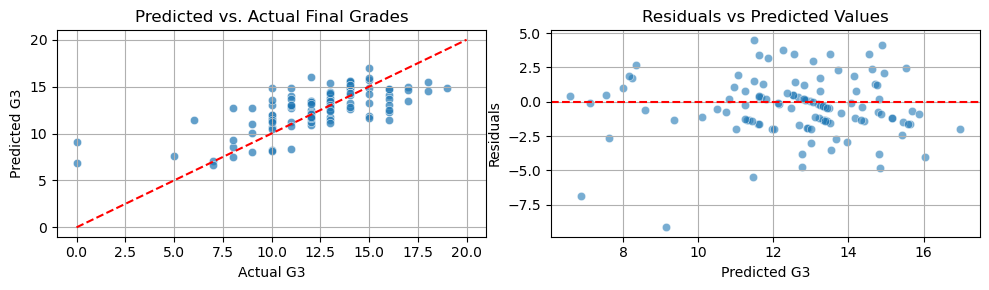

              Model  Mean Absolute Error  Mean Squared Error  \
0  Ridge Regression             1.626755            4.863728   

   Root Mean Squared Error  R Squared  
0                 2.205386   0.470829  
Coefficients: [ 0.3904426   0.112025   -0.06192148  0.16215302  0.27715829 -0.9967667
  0.10602747 -0.13068988 -0.09120459 -0.28380292 -0.1124247  -0.25385053
 -0.00325419  0.25981421 -1.26810688 -0.76931954  0.55306958  0.02773538
 -0.4069779  -0.16843285  0.0904545  -0.10771143  0.30361821 -0.8163391
  0.19472038 -0.79019185  0.73082411  1.11484531 -0.05194846  0.03838032
  0.42451959 -0.80409463 -0.18670784  0.52790257  0.68253016 -0.31894765
 -0.00330293 -0.42381718  0.0635376   0.17116122  0.35430474 -0.60131408
  0.07584812]
Intercept: 3.8727761069997957


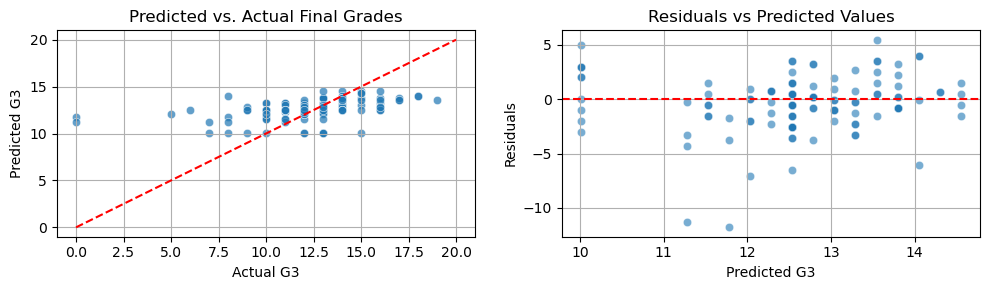

              Model  Mean Absolute Error  Mean Squared Error  \
0  Lasso Regression             1.935582            7.496346   

   Root Mean Squared Error  R Squared  
0                 2.737946   0.184402  
Coefficients: [ 0.         0.         0.        -0.         0.        -0.
  0.        -0.        -0.        -0.        -0.        -0.
 -0.         0.2524243 -0.        -0.         0.        -0.
 -0.         0.         0.         0.        -0.        -0.
  0.        -0.         0.         0.        -0.         0.
  0.        -0.        -0.         0.         0.         0.
  0.        -0.         0.        -0.         0.        -0.
  0.       ]
Intercept: 10.011193379737875


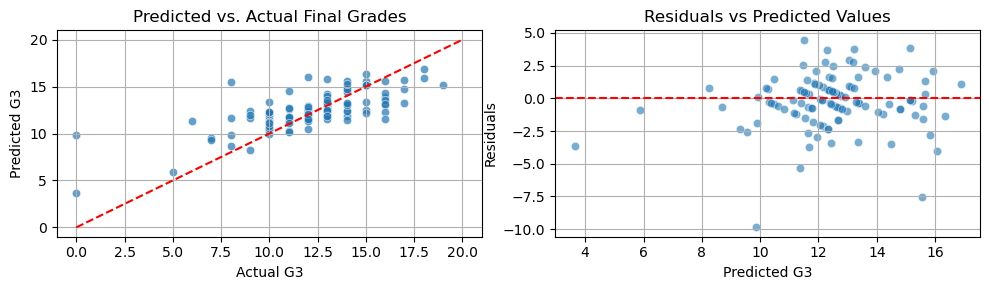

               Model  Mean Absolute Error  Mean Squared Error  \
0  Gradient Boosting             1.481724            4.414038   

   Root Mean Squared Error  R Squared  
0                 2.100961   0.519755  


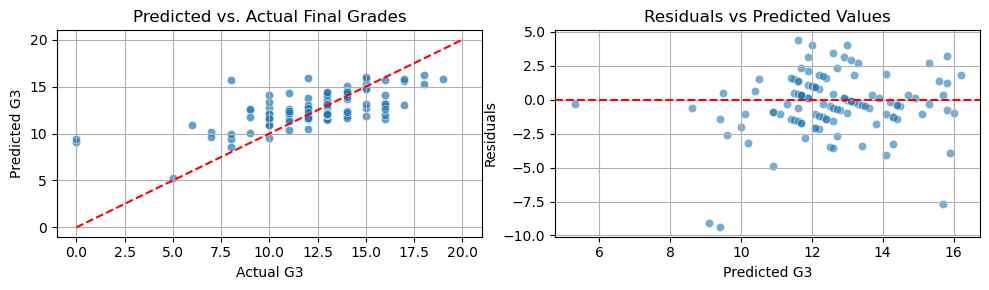

                     Model  Mean Absolute Error  Mean Squared Error  \
0  Random Forest Regressor             1.608696            5.236174   

   Root Mean Squared Error  R Squared  
0                 2.288269   0.430308  


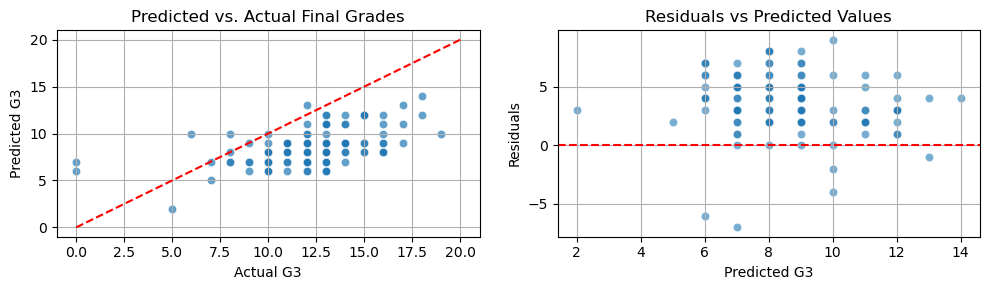

     Model  Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  \
0  XGBoost              3.93913            19.53913                 4.420309   

   R Squared  
0  -1.125845  


Model  Mean Absolute Error  Mean Squared Error  \
0        Gradient Boosting             1.481724            4.414038   
0        Linear Regression             1.632927            4.855443   
0         Ridge Regression             1.626755            4.863728   
0  Random Forest Regressor             1.608696            5.236174   
0         Lasso Regression             1.935582            7.496346   
0                  XGBoost             3.939130           19.539130   

   Root Mean Squared Error  R Squared  
0                 2.100961   0.519755  
0                 2.203507   0.471731  
0                 2.205386   0.470829  
0                 2.288269   0.430308  
0                 2.737946   0.184402  
0                 4.420309  -1.125845

In [1000]:
# Run 6 different models and compare evaluation metrics:
# Linear Regression
lr = LinearRegression()

lr_y_pred = runRegressorModel(lr)
lr_eval = RegressorEvalMetrics("Linear Regression", lr, lr_y_pred)

coefficients = lr.coef_
intercept = lr.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

# Ridge Regression
rr = Ridge(alpha=1.0) # alpha controls the strength of regularization

rr_y_pred = runRegressorModel(rr)
ridge_eval = RegressorEvalMetrics("Ridge Regression", rr, rr_y_pred)

coefficients = rr.coef_
intercept = rr.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

# Lasso Regression
lasso = Lasso(alpha=1.0) # alpha controls the strength of regularization

lasso_y_pred = runRegressorModel(lasso)
lasso_eval = RegressorEvalMetrics("Lasso Regression", lasso, lasso_y_pred)

coefficients = lasso.coef_
intercept = lasso.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

# Gradient Boosting Regression
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

gb = ensemble.GradientBoostingRegressor(**params)

gb_y_pred = runRegressorModel(gb)
gb_eval = RegressorEvalMetrics("Gradient Boosting", gb, gb_y_pred)

# Random Forest Regressor
params = {
    "n_estimators": 10,
    "random_state": 0,
    "oob_score": False
}

rf = RandomForestRegressor(**params)

rf_y_pred = runRegressorModel(rf)
rf_eval = RegressorEvalMetrics("Random Forest Regressor", rf, rf_y_pred)

# XG Boost
params = {
    "objective":'multi:softmax',  # Specify the objective function for multi-class classification
    "num_class":3,                # Specify the number of classes
    "n_estimators":100,           # Number of boosting rounds
    "learning_rate":0.1,          # Step size shrinkage to prevent overfitting
    "max_depth":3,                # Maximum depth of a tree
    "random_state":42             # Random seed for reproducibility
}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

xgboost = XGBClassifier(**params)


xgboost_y_pred = runRegressorModel(xgboost)
xgboost_eval = RegressorEvalMetrics("XGBoost", xgboost, xgboost_y_pred)

# Compare all evaluation metrics
evaluation_metrics = pd.concat([lr_eval, ridge_eval, lasso_eval, gb_eval, rf_eval, xgboost_eval]) # Stacks df3 below df1
evaluation_metrics.sort_values(by='Root Mean Squared Error', ascending=True)

**Tuning Hyperparameters - Gradient Boosting**

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.7}
Best cross-validated RMSE: 2.01
Test RMSE: 4.22
Test R²: -0.94


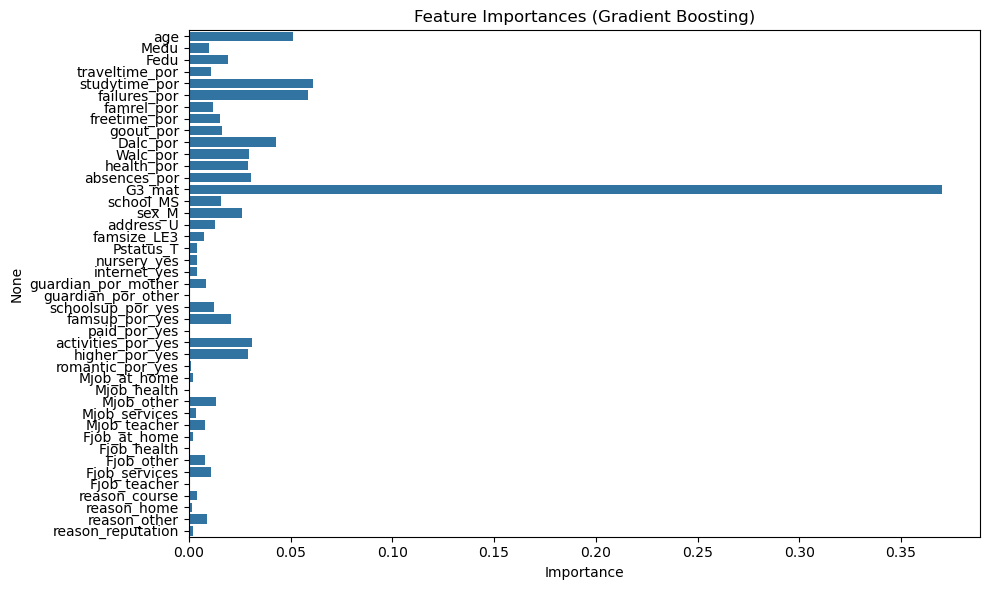

In [1006]:
# Negate RMSE since GridSearchCV minimizes the score
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Set up parameter grid. Use "RandomizedSearchCV" to go faster
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 1.0]}

# Fit with cross validation
gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Examine best model
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated RMSE: {-grid_search.best_score_:.2f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

# Visualize feature importances
feature_importance = best_model.feature_importances_
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'PC{i+1}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [1022]:
# Retraining the model - Gradient Boosting with best parameters
gbr = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=100,
    subsample=0.7,
    random_state=42)

# Cross-validation (5-fold)
cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Train on full training set and evaluate on test set
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

# Calculate RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

cv_rmse_mean = -np.mean(cv_scores)
cv_rmse_std = np.std(cv_scores)

(rmse, r2, cv_rmse_mean, cv_rmse_std)

(4.220732061414073,
 -0.9382151887263186,
 2.0134751956816332,
 0.12536927559727698)

**Cross Validation - Linear Regression**

In [1024]:
# Cross-validation (5-fold)
lr = LinearRegression()

cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Train on full training set and evaluate on test set
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Calculate RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

cv_rmse_mean = -np.mean(cv_scores)
cv_rmse_std = np.std(cv_scores)

(rmse, r2, cv_rmse_mean, cv_rmse_std)

(4.158822551915046, -0.8817728858552141, 2.1947141189905963, 0.174661093056815)

### Classifier Models - Math

In [583]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [775]:
def runClassifierModel(model_name, model):
    model.fit(X_train, y_train) # Train the model
    y_pred = model.predict(X_test) # Make predictions
    return y_pred

def ClassifierEvalMetrics(model_name, model, y_pred, cm=False):
    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred) # percentage of y_pred that matches y_test
    precision = precision_score(y_test, y_pred, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
    recall = recall_score(y_test, y_pred, average='micro', zero_division=np.nan)
    f1 = f1_score(y_test, y_pred, average='micro', zero_division=np.nan)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='micro', multi_class='ovr')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    if cm==True:
        sns.heatmap(conf_matrix, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(2)), yticklabels=list(range(2)))
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.title('Confusion Matrix: ' + model_name,fontsize=16)
        plt.show()
    
    df = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 score': f1, 'ROC_AUC': roc_auc}, index=[0])
    return df  

In [1052]:
# Classifier - MATH
X_train, X_test, y_train, y_test = train_test_split(X_classifier_math, y_classifier_math, test_size=0.3, random_state=42)

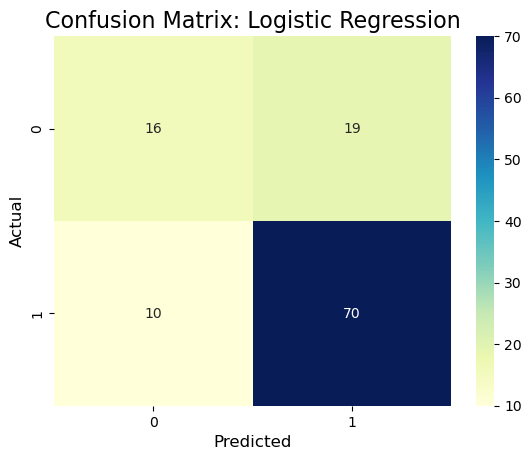

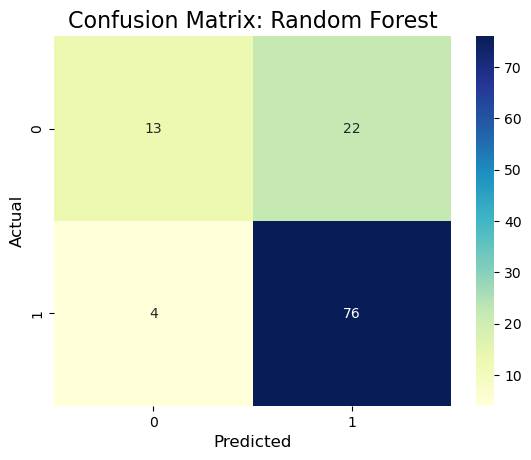

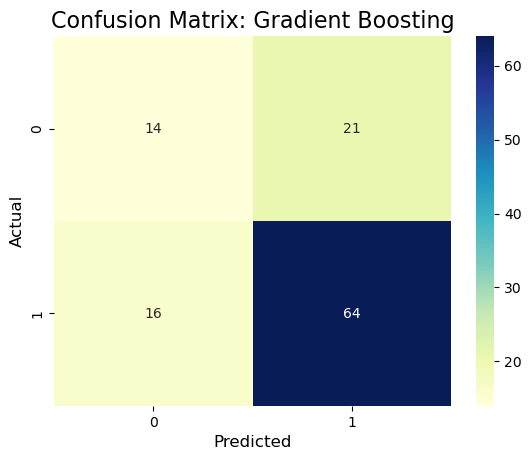

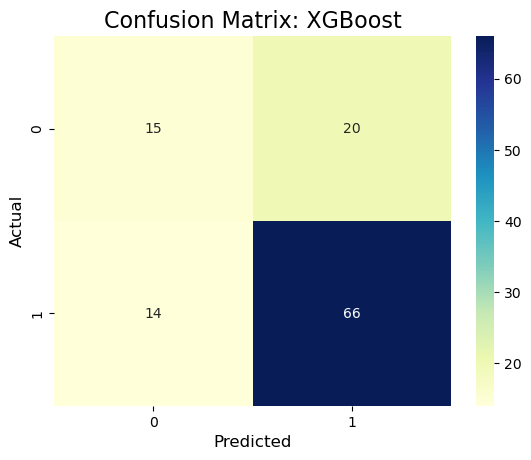

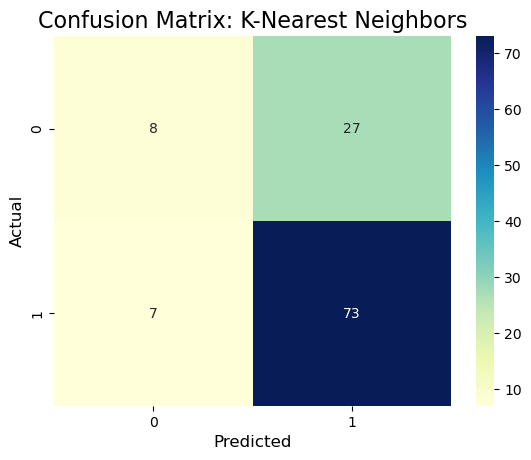

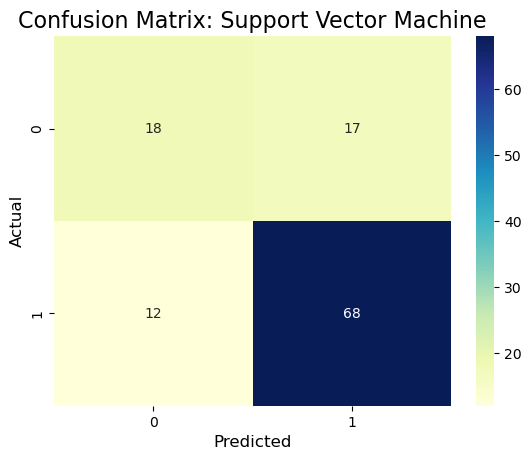

Model  Accuracy  Precision    Recall  F1 score   ROC_AUC
0           Random Forest  0.773913   0.773913  0.773913  0.773913  0.758214
0  Support Vector Machine  0.747826   0.747826  0.747826  0.747826  0.712321
0       Gradient Boosting  0.678261   0.678261  0.678261  0.678261  0.690000
0                 XGBoost  0.704348   0.704348  0.704348  0.704348  0.685714
0     Logistic Regression  0.747826   0.747826  0.747826  0.747826  0.683929
0     K-Nearest Neighbors  0.704348   0.704348  0.704348  0.704348  0.652143

In [1054]:
# Run 6 different Classifier models and evaluate them

# Logistic Regression
lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42)
lr_y_pred = runClassifierModel("Logistic Regression", lr)
lr_eval = ClassifierEvalMetrics("Logistic Regression", lr, lr_y_pred, cm=True)
lr_eval

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_y_pred = runClassifierModel("Random Forest", rf)
rf_eval = ClassifierEvalMetrics("Random Forest", rf, rf_y_pred, cm=True)
rf_eval

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_y_pred = runClassifierModel("Gradient Boosting", gb)
gb_eval = ClassifierEvalMetrics("Gradient Boosting", gb, gb_y_pred, cm=True)
gb_eval

# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')  # For binary classification. Evaluation metric (can be changed)
xgb_y_pred = runClassifierModel("XGBoost", xgb)
xgb_eval = ClassifierEvalMetrics("XGBoost", xgb, xgb_y_pred, cm=True)
xgb_eval

# KNN
knn = KNeighborsClassifier(n_neighbors=11) # adjust n_neighbors
knn_y_pred = runClassifierModel("K-Nearest Neighbors", knn)
knn_eval = ClassifierEvalMetrics("K-Nearest Neighbors", knn, knn_y_pred, cm=True)
knn_eval

# SVC
svm = SVC(C=1.0, kernel='linear', gamma='auto', probability=True) # 'C' is the regularization parameter (smaller values reduce overfitting), 'kernel' can be 'linear', 'poly', 'rbf', 'sigmoid', etc., 'gamma' controls the influence of individual data points (for RBF kernel)
svm_y_pred = runClassifierModel("Support Vector Machine", svm)
svm_eval = ClassifierEvalMetrics("Support Vector Machine", svm, svm_y_pred, cm=True)
svm_eval

# Compare all evaluation metrics
evaluation_metrics = pd.concat([lr_eval, rf_eval, gb_eval, xgb_eval, knn_eval, svm_eval]) # Stacks df3 below df1
evaluation_metrics.sort_values(by='ROC_AUC', ascending=False)

In [1056]:
# List best model based on different metrics
for col in evaluation_metrics.columns:
    evaluation_metrics = evaluation_metrics.sort_values(by=col, ascending=False)
    print("Sort by:", col, evaluation_metrics.iloc[0, 0])

# Note: SVM, Logistic Regression, and Random Forest all have the same scores (except ROC_AUC)

Sort by: Model XGBoost
Sort by: Accuracy Random Forest
Sort by: Precision Random Forest
Sort by: Recall Random Forest
Sort by: F1 score Random Forest
Sort by: ROC_AUC Random Forest


**Model Interpretation**

higher_mat_yes         1.593003
failures_mat          -1.035321
guardian_mat_other    -0.902461
Mjob_services          0.855502
Mjob_teacher          -0.802921
schoolsup_mat_yes     -0.739071
famsize_LE3            0.673087
famsup_mat_yes        -0.581650
Pstatus_T             -0.549766
sex_M                  0.506359
Fjob_health            0.450624
paid_mat_yes           0.440166
goout_mat             -0.438918
Fjob_teacher           0.437478
nursery_yes           -0.403364
reason_other           0.400453
Mjob_health            0.350708
Walc_mat               0.347052
reason_reputation      0.300808
Medu                   0.223675
guardian_mat_mother   -0.193737
Mjob_other             0.192778
internet_yes           0.192488
Dalc_mat               0.182036
famrel_mat             0.170778
Mjob_at_home           0.169924
Fjob_services         -0.159160
Fedu                   0.147593
traveltime_mat        -0.147312
studytime_mat          0.134647
age                   -0.112518
Fjob_oth

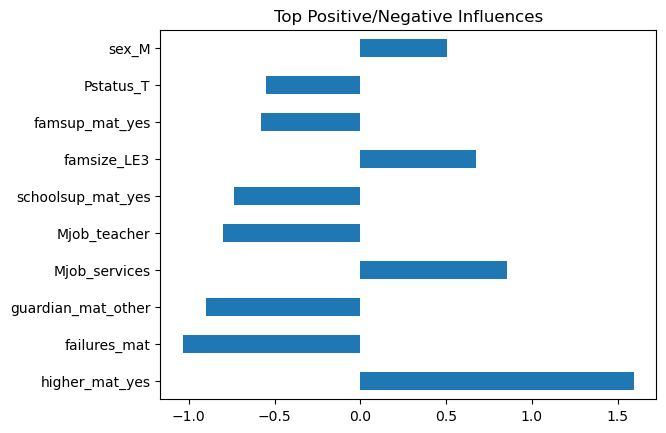

In [1058]:
# Examining Logistic Regression coefficients
coefficients = pd.Series(lr.coef_[0], index=X_classifier_math.columns)
coefficients = coefficients.sort_values(key=abs, ascending=False)
print(coefficients)

coefficients.head(10).plot(kind='barh', title='Top Positive/Negative Influences')
plt.show()

absences_mat           0.089746
failures_mat           0.085536
age                    0.053259
freetime_mat           0.049284
goout_mat              0.044956
Medu                   0.044006
Fedu                   0.039978
health_mat             0.037586
Walc_mat               0.036605
studytime_mat          0.033324
famrel_mat             0.029461
traveltime_mat         0.023308
sex_M                  0.023039
paid_mat_yes           0.022396
Dalc_mat               0.021175
famsup_mat_yes         0.019696
Mjob_services          0.019448
famsize_LE3            0.018985
reason_course          0.018615
nursery_yes            0.018253
higher_mat_yes         0.017847
activities_mat_yes     0.017232
romantic_mat_yes       0.017079
Mjob_other             0.016124
schoolsup_mat_yes      0.015545
guardian_mat_mother    0.015322
Fjob_services          0.015309
internet_yes           0.014557
Mjob_at_home           0.014198
reason_reputation      0.014122
Mjob_teacher           0.013744
reason_h

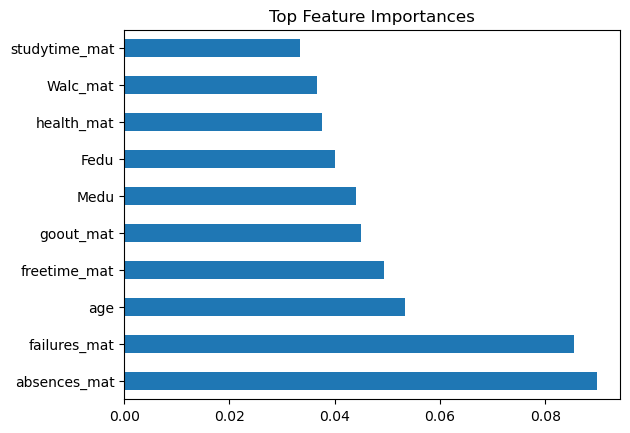

In [1062]:
# Examining Random Forest feature importance scores
importances = pd.Series(rf.feature_importances_, index=X_classifier_math.columns)
importances = importances.sort_values(ascending=False)
print(importances)

importances.head(10).plot(kind='barh', title='Top Feature Importances')
plt.show()

**Hyperparameter Tuning**

In [1067]:
# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # explore regularization strengths
    'solver': ['liblinear', 'saga']}

lr = LogisticRegression(max_iter=1000)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

{'C': 100, 'solver': 'liblinear'}
0.7305597326649957


C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [1087]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
0.7384294068504594


In [1071]:
# Hyperparameter tuning for Support Vector Machine
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # only matters for 'rbf' kernel
}

svc = SVC(probability=True)  # needed for ROC AUC
grid = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best ROC AUC score:", grid.best_score_)

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best ROC AUC score: 0.7392481203007518


In [1073]:
# Hyperparameter tuning for Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'max_features': ['sqrt', 'log2', None]
}

rand_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
print("Best Parameters:", rand_search.best_params_)
print("Best ROC AUC Score:", rand_search.best_score_)

Best Parameters: {'learning_rate': 0.07238249886045664, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 143, 'subsample': 0.9757995766256756}
Best ROC AUC Score: 0.7443609022556392


**Repeat Modeling**

In [1089]:
# Repeating all models...

# Logistic Regression
lr = LogisticRegression(solver='liblinear', C=100, multi_class='ovr', random_state=42)
lr_y_pred = runClassifierModel("Logistic Regression", lr)
lr_eval = ClassifierEvalMetrics("Logistic Regression", lr, lr_y_pred, cm=False)
lr_eval

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None, min_samples_split=2, random_state=42)
rf_y_pred = runClassifierModel("Random Forest", rf)
rf_eval = ClassifierEvalMetrics("Random Forest", rf, rf_y_pred, cm=False)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=143, learning_rate=0.07238249886045664, max_depth=6, max_features='log2', min_samples_leaf=2, min_samples_split=3, subsample=0.9757995766256756, random_state=42)
gb_y_pred = runClassifierModel("Gradient Boosting", gb)
gb_eval = ClassifierEvalMetrics("Gradient Boosting", gb, gb_y_pred, cm=False)

# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')  # For binary classification. Evaluation metric (can be changed)
xgb_y_pred = runClassifierModel("XGBoost", xgb)
xgb_eval = ClassifierEvalMetrics("XGBoost", xgb, xgb_y_pred, cm=False)

# KNN
knn = KNeighborsClassifier(n_neighbors=6) # adjust n_neighbors
knn_y_pred = runClassifierModel("K-Nearest Neighbors", knn)
knn_eval = ClassifierEvalMetrics("K-Nearest Neighbors", knn, knn_y_pred, cm=False)

# SVC
svm = SVC(C=0.1, kernel='linear', gamma='scale', probability=True) # 'C' is the regularization parameter (smaller values reduce overfitting), 'kernel' can be 'linear', 'poly', 'rbf', 'sigmoid', etc., 'gamma' controls the influence of individual data points (for RBF kernel)
svm_y_pred = runClassifierModel("Support Vector Machine", svm)
svm_eval = ClassifierEvalMetrics("Support Vector Machine", svm, svm_y_pred, cm=False)

In [1091]:
# Compare all evaluation metrics
evaluation_metrics = pd.concat([lr_eval, rf_eval, gb_eval, xgb_eval, knn_eval, svm_eval]) # Stacks df3 below df1
evaluation_metrics.sort_values(by='ROC_AUC', ascending=False)

Model  Accuracy  Precision    Recall  F1 score   ROC_AUC
0  Support Vector Machine  0.739130   0.739130  0.739130  0.739130  0.725714
0           Random Forest  0.730435   0.730435  0.730435  0.730435  0.725179
0       Gradient Boosting  0.704348   0.704348  0.704348  0.704348  0.685714
0                 XGBoost  0.704348   0.704348  0.704348  0.704348  0.685714
0     K-Nearest Neighbors  0.704348   0.704348  0.704348  0.704348  0.682857
0     Logistic Regression  0.756522   0.756522  0.756522  0.756522  0.682143

In [1079]:
# List best model based on different metrics
for col in evaluation_metrics.columns:
    evaluation_metrics = evaluation_metrics.sort_values(by=col, ascending=False)
    print("Sort by:", col, evaluation_metrics.iloc[0, 0])

# Note: SVM, Logistic Regression, and Random Forest all have the same scores (except ROC_AUC)

Sort by: Model XGBoost
Sort by: Accuracy Random Forest
Sort by: Precision Random Forest
Sort by: Recall Random Forest
Sort by: F1 score Random Forest
Sort by: ROC_AUC Random Forest


higher_mat_yes         2.349051
Mjob_services          1.852567
guardian_mat_other    -1.800849
Fjob_health            1.521729
reason_other           1.518298
schoolsup_mat_yes     -1.499436
Fjob_teacher           1.464512
Mjob_health            1.338730
reason_reputation      1.325074
Pstatus_T             -1.296756
failures_mat          -1.287355
reason_course          1.189818
reason_home            1.080863
Mjob_other             1.037038
Mjob_at_home           1.009271
Fjob_other             0.846569
famsup_mat_yes        -0.838567
famsize_LE3            0.822900
paid_mat_yes           0.687564
Fjob_at_home           0.684353
guardian_mat_mother   -0.665336
nursery_yes           -0.604108
Fjob_services          0.596889
sex_M                  0.580183
goout_mat             -0.428992
age                   -0.427390
Walc_mat               0.390576
traveltime_mat        -0.356560
address_U             -0.346979
school_MS              0.342326
Dalc_mat               0.262423
Medu    

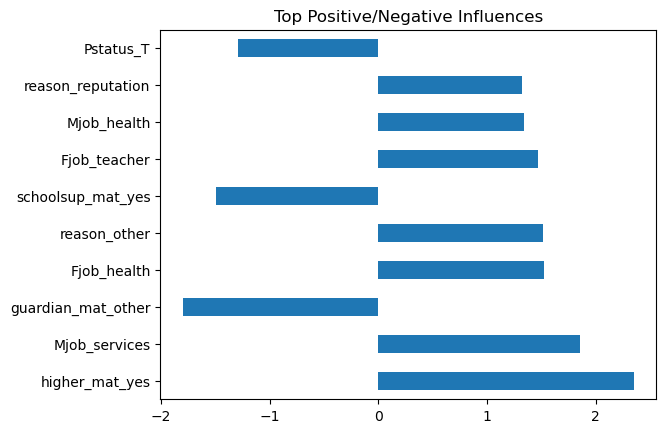

In [1083]:
# Examining Logistic Regression coefficients (again)
coefficients = pd.Series(lr.coef_[0], index=X_classifier_math.columns)
coefficients = coefficients.sort_values(key=abs, ascending=False)
print(coefficients)

coefficients.head(10).plot(kind='barh', title='Top Positive/Negative Influences')
plt.show()

absences_mat           0.090682
failures_mat           0.085120
age                    0.057326
goout_mat              0.054004
freetime_mat           0.047790
Fedu                   0.047059
Walc_mat               0.038900
health_mat             0.038215
Medu                   0.035499
studytime_mat          0.032254
famrel_mat             0.028053
sex_M                  0.027419
higher_mat_yes         0.024152
Dalc_mat               0.022356
famsize_LE3            0.020086
traveltime_mat         0.019516
paid_mat_yes           0.019018
schoolsup_mat_yes      0.018290
Mjob_services          0.017854
reason_course          0.017360
romantic_mat_yes       0.016509
internet_yes           0.015750
famsup_mat_yes         0.015372
Mjob_at_home           0.015239
guardian_mat_mother    0.014897
Mjob_teacher           0.014811
reason_reputation      0.014726
reason_home            0.013873
guardian_mat_other     0.013465
activities_mat_yes     0.013442
Fjob_other             0.013399
nursery_

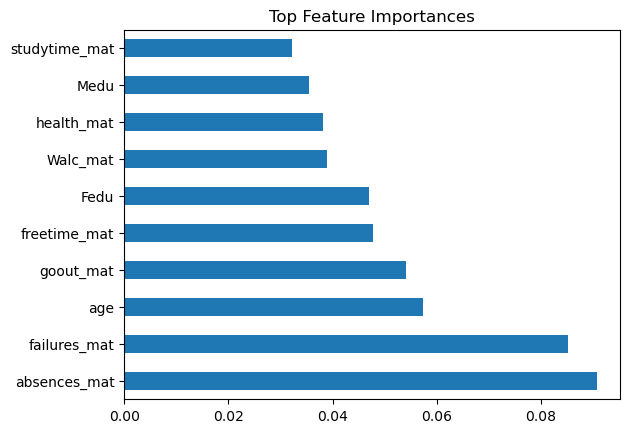

In [1085]:
# Examining Random Forest feature importance scores (again)
importances = pd.Series(rf.feature_importances_, index=X_classifier_math.columns)
importances = importances.sort_values(ascending=False)
print(importances)

importances.head(10).plot(kind='barh', title='Top Feature Importances')
plt.show()

In [1093]:
# Cross Validation with Random Forest

rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {np.mean(scores):.4f}")
print(f"Std of cross-validation score: {np.std(scores):.4f}")

Cross-validation scores: [0.68518519 0.7962963  0.73584906 0.71698113 0.79245283]
Mean cross-validation score: 0.7454
Std of cross-validation score: 0.0432


### Classifier Models - Portuguese

In [1097]:
# Classifier - PORTUGUESE
X_train, X_test, y_train, y_test = train_test_split(X_classifier_por, y_classifier_por, test_size=0.3, random_state=42)

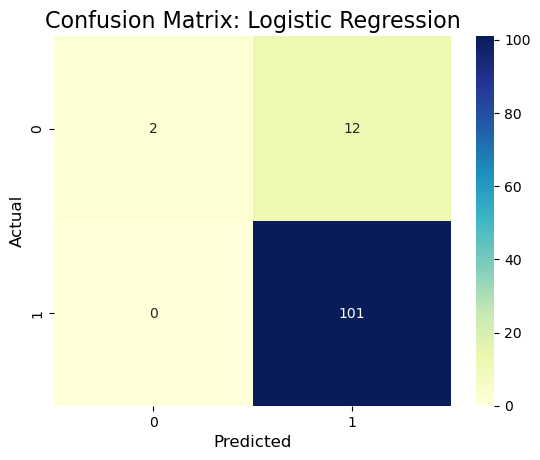

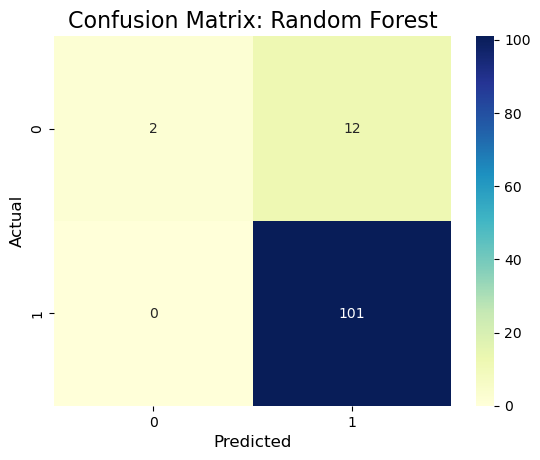

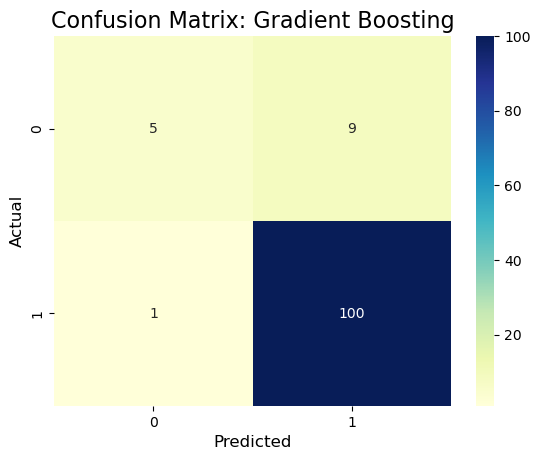

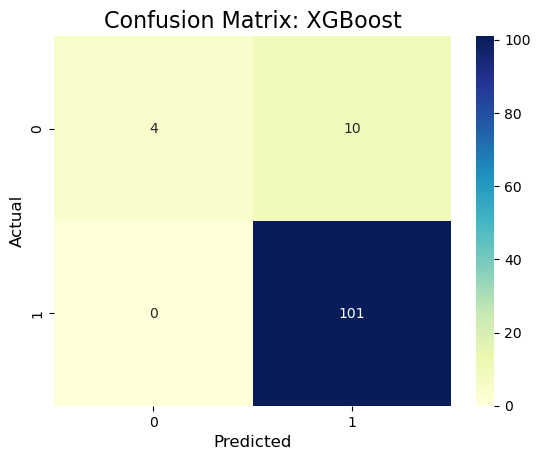

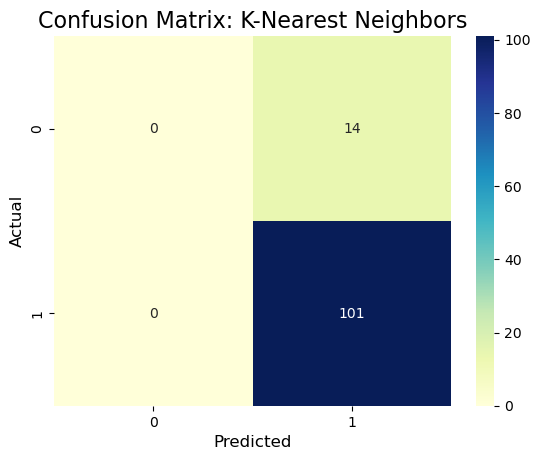

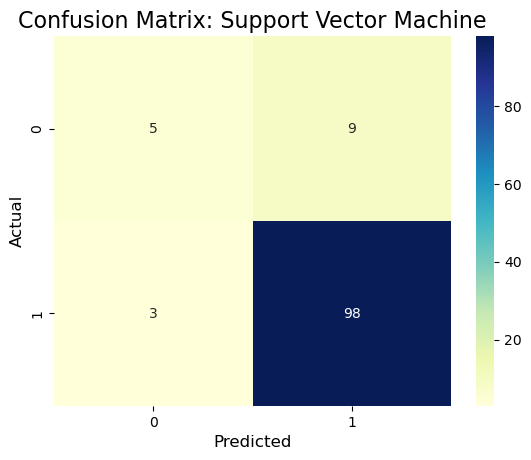

Model  Accuracy  Precision    Recall  F1 score   ROC_AUC
0           Random Forest  0.895652   0.895652  0.895652  0.895652  0.942008
0     Logistic Regression  0.895652   0.895652  0.895652  0.895652  0.886139
0       Gradient Boosting  0.913043   0.913043  0.913043  0.913043  0.862093
0  Support Vector Machine  0.895652   0.895652  0.895652  0.895652  0.854314
0                 XGBoost  0.913043   0.913043  0.913043  0.913043  0.853607
0     K-Nearest Neighbors  0.878261   0.878261  0.878261  0.878261  0.756719

In [1099]:
# Run 6 different Classifier models and evaluate them

# Logistic Regression
lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42)
lr_y_pred = runClassifierModel("Logistic Regression", lr)
lr_eval = ClassifierEvalMetrics("Logistic Regression", lr, lr_y_pred, cm=True)
lr_eval

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_y_pred = runClassifierModel("Random Forest", rf)
rf_eval = ClassifierEvalMetrics("Random Forest", rf, rf_y_pred, cm=True)
rf_eval

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_y_pred = runClassifierModel("Gradient Boosting", gb)
gb_eval = ClassifierEvalMetrics("Gradient Boosting", gb, gb_y_pred, cm=True)
gb_eval

# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')  # For binary classification. Evaluation metric (can be changed)
xgb_y_pred = runClassifierModel("XGBoost", xgb)
xgb_eval = ClassifierEvalMetrics("XGBoost", xgb, xgb_y_pred, cm=True)
xgb_eval

# KNN
knn = KNeighborsClassifier(n_neighbors=11) # adjust n_neighbors
knn_y_pred = runClassifierModel("K-Nearest Neighbors", knn)
knn_eval = ClassifierEvalMetrics("K-Nearest Neighbors", knn, knn_y_pred, cm=True)
knn_eval

# SVC
svm = SVC(C=1.0, kernel='linear', gamma='auto', probability=True) # 'C' is the regularization parameter (smaller values reduce overfitting), 'kernel' can be 'linear', 'poly', 'rbf', 'sigmoid', etc., 'gamma' controls the influence of individual data points (for RBF kernel)
svm_y_pred = runClassifierModel("Support Vector Machine", svm)
svm_eval = ClassifierEvalMetrics("Support Vector Machine", svm, svm_y_pred, cm=True)
svm_eval

# Compare all evaluation metrics
evaluation_metrics = pd.concat([lr_eval, rf_eval, gb_eval, xgb_eval, knn_eval, svm_eval]) # Stacks df3 below df1
evaluation_metrics.sort_values(by='ROC_AUC', ascending=False)

In [1101]:
# List best model based on different metrics
for col in evaluation_metrics.columns:
    evaluation_metrics = evaluation_metrics.sort_values(by=col, ascending=False)
    print("Sort by:", col, evaluation_metrics.iloc[0, 0])

# Note: SVM, Logistic Regression, and Random Forest all have the same scores (except ROC_AUC)

Sort by: Model XGBoost
Sort by: Accuracy XGBoost
Sort by: Precision XGBoost
Sort by: Recall XGBoost
Sort by: F1 score XGBoost
Sort by: ROC_AUC Random Forest


In [1103]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
0.7885782312925169


In [1106]:
# Repeating Random Forest with best parameters
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='log2', min_samples_split=5, random_state=42)
rf_y_pred = runClassifierModel("Random Forest", rf)
rf_eval = ClassifierEvalMetrics("Random Forest", rf, rf_y_pred, cm=False)

higher_mat_yes         0.094437
Dalc_mat               0.060650
freetime_mat           0.060169
goout_mat              0.055736
famrel_mat             0.050057
Fedu                   0.046082
absences_mat           0.044724
Medu                   0.043031
failures_mat           0.040574
age                    0.036537
Walc_mat               0.036427
studytime_mat          0.033391
famsup_mat_yes         0.030019
health_mat             0.028561
paid_mat_yes           0.027787
Mjob_other             0.025648
activities_mat_yes     0.025514
school_MS              0.023287
Fjob_services          0.022869
reason_other           0.019607
traveltime_mat         0.018364
address_U              0.017960
guardian_mat_mother    0.015789
Mjob_at_home           0.015400
reason_home            0.013761
Fjob_other             0.012106
internet_yes           0.011943
sex_M                  0.010628
famsize_LE3            0.009778
romantic_mat_yes       0.009522
nursery_yes            0.009513
Fjob_hea

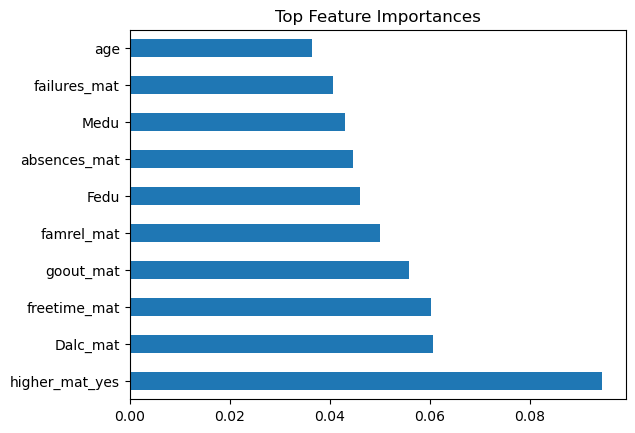

In [1108]:
# Examining Random Forest feature importance scores (again)
importances = pd.Series(rf.feature_importances_, index=X_classifier_math.columns)
importances = importances.sort_values(ascending=False)
print(importances)

importances.head(10).plot(kind='barh', title='Top Feature Importances')
plt.show()

## 5) Conclusion